# 33150 PSET 2
# Giovanni Longo (12228450)

## ETFs Used Were HYLD and JNK

### ChatGPT was used to help with the creation of code for repetitive tasks (such as creating plots). One example of a prompt that was used was "I have a list of spread values and a pandas data frame column of dates, and I want to use plotnine to plot the spread values (y-axis) against the dates (x-axis). Please give code that can make this plot and also give it a title saying 'HYLD - JNK Spreads from January 1, 2022 to November 15, 2023'. Title the x-axis as 'Date' and the y-axis as 'spread value'".

#### Begin by importing necessary libraries and setting varibales.

In [99]:
from plotnine import aes
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import patchworklib as pw
import itertools
import plotnine as p9
import datetime
import os

quandl.ApiConfig.api_key = '1n-fMYgMqmbySCU-zs6e'
start_date = '2021-12-02' 
end_date = '2023-11-15'

#### Code has been adapted from the provided fetch function on Canvas. For the variable ```root_data_dir```, the parameter ```os.environ['HOME']``` has been changed to ```os.getcwd()```, and the function only worked when changing ```os.mkdir``` to ```os.makedirs``` under the ```table_dir``` if clause.

In [100]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(table_path, filename=data_file, api_key='1n-fMYgMqmbySCU-zs6e', **kwargs)
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

#### We grab the relevant tickers based on student ID and sort the tables to include only the relevent dates that we wish to analyze.

In [101]:
ticker_list = ['RINC', 'JNK', 'SVOL']
data = fetch_quandl_table('QUOTEMEDIA/PRICES', ticker=ticker_list, avoid_download=False)

SVOL_data = data[data['ticker'] == 'SVOL']
sorted_SVOL_data = SVOL_data[(SVOL_data['date'] >= start_date) & (SVOL_data['date'] <= end_date)].sort_values('date').set_index('date')

HYLD_data = data[data['ticker'] == 'RINC']
sorted_HYLD_data = HYLD_data[(HYLD_data['date'] >= start_date) & (HYLD_data['date'] <= end_date)].sort_values('date').set_index('date')

JNK_data = data[data['ticker'] == 'JNK']
sorted_JNK_data = JNK_data[(JNK_data['date'] >= start_date) & (JNK_data['date'] <= end_date)].sort_values('date').set_index('date')

Data file C:\Users\giova\OneDrive\Desktop\FINM\Winter FINM\FINM 33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240122.zip size 339725 exists already, no need to download


#### First, we want to figure out which of the two ETFs is less liquid, which can be done by finding which one has consistently lower trading volume.

In [102]:
sorted_HYLD_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2021-12-02,RINC,31.4700,31.5500,31.4500,31.5200,28908.0,0.0,1.0,29.913848,29.989892,29.894837,29.961375,28908.0
2021-12-03,RINC,31.5800,31.6000,31.4400,31.5550,12527.0,0.0,1.0,30.018408,30.037419,29.885331,29.994645,12527.0
2021-12-06,RINC,31.5400,31.6500,31.5400,31.6129,16162.0,0.0,1.0,29.980386,30.084947,29.980386,30.049681,16162.0
2021-12-07,RINC,31.7400,31.7400,31.6500,31.6661,7904.0,0.0,1.0,30.170497,30.170497,30.084947,30.100251,7904.0
2021-12-08,RINC,31.6300,31.8000,31.6200,31.7265,9064.0,0.0,1.0,30.065936,30.227530,30.056430,30.157664,9064.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,RINC,23.4168,23.4168,22.6899,22.6899,1070.0,0.0,1.0,23.416800,23.416800,22.689900,22.689900,1070.0
2023-11-10,RINC,22.8929,22.9006,22.7800,22.9006,2468.0,0.0,1.0,22.892900,22.900600,22.780000,22.900600,2468.0
2023-11-13,RINC,22.2300,22.8301,21.7000,22.8196,10710.0,0.0,1.0,22.230000,22.830100,21.700000,22.819600,10710.0


In [103]:
sorted_JNK_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2021-12-02,JNK,106.595,107.360,106.580,107.29,11804201.0,0.0,1.0,97.595273,98.295684,97.581539,98.231594,11804201.0
2021-12-03,JNK,107.340,107.400,107.070,107.28,17457166.0,0.0,1.0,98.277373,98.332307,98.030169,98.222439,17457166.0
2021-12-06,JNK,107.370,107.865,107.290,107.68,11047416.0,0.0,1.0,98.304840,98.758048,98.231594,98.588667,11047416.0
2021-12-07,JNK,108.120,108.590,108.070,108.34,14624386.0,0.0,1.0,98.991518,99.421837,98.945740,99.192944,14624386.0
2021-12-08,JNK,108.290,108.360,108.140,108.36,10377204.0,0.0,1.0,99.147165,99.211255,99.009830,99.211255,10377204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,JNK,90.750,90.865,90.220,90.25,9789832.0,0.0,1.0,89.747981,89.861711,89.223833,89.253501,9789832.0
2023-11-10,JNK,90.450,90.720,90.430,90.71,6244579.0,0.0,1.0,89.451293,89.718312,89.431514,89.708422,6244579.0
2023-11-13,JNK,90.480,90.670,90.375,90.55,6600428.0,0.0,1.0,89.480962,89.668864,89.377121,89.550189,6600428.0


#### From the two data sets, we can clearly see that the HYLD ETF is much less liquid. Now that we have the ETF data within our given time range and know which of the two is less liquid, we need to find the daily dollar volume and compute the running trailing 15-day median.

In [104]:
def compute_rolling_median(etf, rolling_window=15):
    etf['daily_dollar_volume'] = etf['adj_close'] * etf['adj_volume']
    etf['running_median'] = etf['daily_dollar_volume'].rolling(window=rolling_window, min_periods=rolling_window).median()
    
    return etf

In [105]:
JNK_with_median = compute_rolling_median(sorted_JNK_data)
HYLD_with_median = compute_rolling_median(sorted_HYLD_data)
illiquid_median_df = HYLD_with_median['running_median'].to_frame()

#### Now that we have the rolling median for the less liquid of the two ETFs, we must collect the final piece of our data through the Fama-French csv file found online. Since the dates are not immediately in the correct format from the website, we adjust them below using the pandas datetime function.

In [106]:
fama_french_data = pd.read_csv('Developed_3_Factors_Daily.csv')
fama_french_data = fama_french_data.rename(columns={'Unnamed: 0':'date'})
fama_french_data['date'] = pd.to_datetime(fama_french_data['date'].astype(str), format='%Y%m%d')
fama_french_data.set_index('date', inplace=True)

In [107]:
fama_french_data

,Mkt-RF,SMB,HML,RF
date,,,,
1990-07-02,0.69,-0.06,-0.33,0.03
1990-07-03,0.18,0.07,-0.15,0.03
1990-07-04,0.62,-0.17,-0.17,0.03
1990-07-05,-0.74,0.29,0.14,0.03
1990-07-06,0.20,-0.17,0.02,0.03
...,...,...,...,...
2023-12-25,-0.02,-0.05,0.00,0.02
2023-12-26,0.39,0.22,0.19,0.02
2023-12-27,0.45,0.45,-0.18,0.02


#### With the data correctly loaded and formatted, we can now begin implementing our spread strategy. We create a SpreadReversionStrategy class for several reasons. Firstly, since we want to track both a daily and cumulative PnL, it will be useful to have a class structure that can house all these calculations internally. Along those same lines, we also want to be able to exit and enter positions without copying large amounts of code, which can be done within a class with a simple internal function call. Finally, it allows us to rapidly find bugs and discrepancies in logic since each individual issue is isolated into its respective class function. 

#### We start by creating a helper function that allows us to compile a daily dictionary of all the relevant information we will need for later analysis. Since we are consistently altering this daily dictionary, it is useful to make a quick function call rather than have the base class code cluttered with each individual dictionary creation.

In [108]:
def update_daily_dict(
        daily_dict, 
        position_change, 
        long_position_amount,
        short_position_amount,
        daily_pnl, 
        cumulative_pnl,
        capital
    ):
    '''
    Helper function that will return a dictionary of the relevant information needed to
    store in our trading log for the spread_reversion_strategy function.
    '''
    daily_dict['position_change'] = position_change
    daily_dict['long_position_amount'] = long_position_amount
    daily_dict['short_position_amount'] = short_position_amount
    daily_dict['daily_pnl'] = daily_pnl
    daily_dict['cumulative_pnl'] = cumulative_pnl
    daily_dict['capital'] = capital
    
    return daily_dict

#### The code has been split into easy to understand chunks with comments to guide fellow developers through the logic of the spread trading. Corner cases have been carefully debugged and isolated to ensure that any generic input of parameters (under the appropriate base assumptions like the spread enter g being larger than the spread exit j). Some of the issues that were considered and improved include:

-Avoid double counting PnL calculations in the event of a spread remaining above the enter level.
-Fine-tuning the code so that the `position_change` variable accounts for each individual possibility of spread movement.
-Correctly resetting class variables when exiting and entering positions to display the appropriate daily and cumulative PnL as well as to avoid entering and exiting positions at the wrong time.
-Implementing a `maintain_position` function for the (likely) scenario that a spread does not have enough movement to exit or hit a stop_loss, in which case we only have to calculate the PnL produced by that daily movement.
 

In [109]:
class SpreadReversionStrategy:
    def __init__(
            self, 
            etf_list, 
            median_df, 
            trade_start, 
            trade_end, 
            spread_exit, 
            spread_enter, 
            stop_loss_cutoff, 
            trade_cost, 
            return_period, 
            capital
        ):
        self.liquid_etf, self.illiquid_etf = etf_list
        
        # Find our M-day return for both the illiquid and liquid asset
        self.liquid_etf['M_day_return'] = self.liquid_etf['adj_close'].pct_change(periods=return_period)
        self.illiquid_etf['M_day_return'] = self.illiquid_etf['adj_close'].pct_change(periods=return_period)
        
        # Filter our data sets to include only relevant trading days
        self.liquid_etf = self.liquid_etf[(self.liquid_etf['date'] > trade_start) & (self.liquid_etf['date'] <= trade_end)]
        self.illiquid_etf = self.illiquid_etf[(self.illiquid_etf['date'] > trade_start) & (self.illiquid_etf['date'] <= trade_end)]
        self.median_df = median_df[(median_df['date'] >= trade_start) & (median_df['date'] <= trade_end)]
        
        # Initialize variable parameters
        self.last_day = self.liquid_etf['date'].iloc[-1]
        self.spread_exit = spread_exit
        self.spread_enter = spread_enter
        self.stop_loss_cutoff = stop_loss_cutoff
        self.trade_cost = trade_cost
        self.capital = capital
        
        # Initialize the variables needed for our trading logs and PnL, as well as a variable for a reset in the case of 
        # hitting a stop loss
        self.position_type = None
        self.position_change = 'none'
        self.long_enter_amount = 0
        self.short_enter_amount = 0
        self.long_current_amount = 0
        self.short_current_amount = 0
        self.position_value = 0
        self.liquid_trade_size = 0
        self.illiquid_trade_size = 0
        self.daily_pnl = 0
        self.cumulative_pnl = 0
        self.spread_data = []
        self.trade_log = [] 
        self.stop_loss_reset = True
    
    
    def enter_position(self, liquid_row, illiquid_row, daily_median):
        '''
        Intakes the different ETF rows and median value for a specific date and updates
        the relevant information for the entered spread position.
        '''
        # Find the correct amount of each ETF that we should trade based on the daily median
        trade_size = daily_median/100
        self.liquid_trade_size = round(trade_size / liquid_row['adj_close'])
        self.illiquid_trade_size = round(trade_size / illiquid_row['adj_close'])
        
        if illiquid_row['M_day_return'] < liquid_row['M_day_return']:
            self.position_type = 'short'
            self.long_enter_amount = self.illiquid_trade_size*illiquid_row['adj_close']
            self.short_enter_amount = self.liquid_trade_size*liquid_row['adj_close']
        else:
            self.position_type = 'long'
            self.long_enter_amount = self.liquid_trade_size*liquid_row['adj_close']
            self.short_enter_amount = self.illiquid_trade_size*illiquid_row['adj_close']
        
        self.position_value = self.long_enter_amount + self.short_enter_amount
        
        # We need to account for the total transaction cost of the trade, so we multiply the static self.trade_cost
        # parameter by the total entry cost of the position
        transaction_cost = self.trade_cost * self.position_value
        
        # We need to change our capital according to our trading volume and long/short positions
        self.capital = self.capital - self.long_enter_amount + self.short_enter_amount - transaction_cost
        self.cumulative_pnl -= transaction_cost
        self.long_current_amount = self.long_enter_amount
        self.short_current_amount = self.short_enter_amount
        self.position_change = f'none to {self.position_type}'
    
    
    def exit_position(self):
        '''
        Exits the current spread and adjusts the trading log parameters accordingly.
        '''
        transaction_cost = self.trade_cost * (self.long_current_amount + self.short_current_amount)
        self.capital = self.capital + self.long_current_amount - self.short_current_amount - transaction_cost
        self.cumulative_pnl -= transaction_cost
        
        # Reset relevant parameters to their original state
        self.long_enter_amount = 0
        self.short_enter_amount = 0
        self.long_current_amount = 0
        self.short_current_amount = 0
        self.position_value = 0
        self.liquid_trade_size = 0
        self.illiquid_trade_size = 0
        
        self.position_change = f'{self.position_type} to none'
        self.position_type = None
        
    
    def maintain_position(self, liquid_row, illiquid_row, repeat_pnl=False):
        '''
        This is the case where we maintain our current spread position, which means we calculate PnL and 
        avoid other changes.
        '''
        # Only calculate PnL and position change if we have a position
        if self.position_type:
            if not repeat_pnl:
                self.calculate_daily_pnl(liquid_row, illiquid_row)
            self.position_change = f'staying {self.position_type}'
        else:
            self.daily_pnl = 0
            self.position_change = 'none'
    
    
    def calculate_daily_pnl(self, liquid_row, illiquid_row):
        '''
        Calculates the daily PnL for the current spread position based on the movement of the liquid and
        illiquid ETFs for a given date.
        '''
        # Calculate the daily PnL of the current position
        previous_long_balance = self.trade_log[-1]['long_position_amount']
        previous_short_balance = self.trade_log[-1]['short_position_amount']
        self.long_current_amount = self.liquid_trade_size*liquid_row['adj_close']
        self.short_current_amount = self.illiquid_trade_size*illiquid_row['adj_close']
        
        # Change the current values of the current long and short amounts to satisfy a short strategy
        # if that is our current position type
        if self.position_type == 'short':
            self.long_current_amount = self.illiquid_trade_size*illiquid_row['adj_close']
            self.short_current_amount = self.liquid_trade_size*liquid_row['adj_close']
            
        # We want the short price to drop with time and the long price to increase with time. This is why we have
        # defined our short gains as the previous - current and the buy gains as current - previous
        short_gains = previous_short_balance - self.short_current_amount
        long_gains = self.long_current_amount - previous_long_balance
        self.daily_pnl = long_gains + short_gains
        self.cumulative_pnl += self.daily_pnl
        self.position_value += self.daily_pnl
    
    
    def create_spread_trade_log(self):
        '''
        Function that takes in the various parameters necessary to execute a spread strategy and
        returns a dataframe with the trading log of the daily position type, position amount, capital
        amount, trade amount, and PnL for each day.
        '''
        for date in self.liquid_etf['date']:
            daily_dict = {'date':date}
            liquid_row = self.liquid_etf[self.liquid_etf['date'] == date].iloc[0]
            illiquid_row = self.illiquid_etf[self.illiquid_etf['date'] == date].iloc[0]
            daily_median = self.median_df[self.median_df['date'] == date].iloc[0]['running_median']
            difference = illiquid_row['M_day_return'] - liquid_row['M_day_return']
            self.spread_data.append(difference)
            spread = abs(difference)
            
            # We need to do a check for a new month to begin if our stop loss hit the previous month
            if not self.stop_loss_reset:
                last_trading_day = int(self.trade_log[-1]['date'][-2:])
                current_trading_day = int(date[-2:])
                
                if last_trading_day > current_trading_day:
                    self.stop_loss_reset = True
                else:
                    daily_dict = update_daily_dict(daily_dict, 'waiting for reset', 0, 0, 0, self.cumulative_pnl, self.capital)
                    self.trade_log.append(daily_dict)
                    if date == self.last_day:
                        return pd.DataFrame(self.trade_log)
                    else:
                        continue
                        
            # Close all positions and return the trade log once we have reached the final day
            if date == self.last_day:
                self.calculate_daily_pnl(liquid_row, illiquid_row)
                self.exit_position()
                daily_dict = update_daily_dict(daily_dict, 'end of period', 0, 0, self.daily_pnl, self.cumulative_pnl, self.capital)
                self.trade_log.append(daily_dict)
                return pd.DataFrame(self.trade_log)
    
            # Determine whether to enter, maintain, or exit a position
            if spread > self.spread_enter:
                if self.position_type is None:
                    self.enter_position(liquid_row, illiquid_row, daily_median)
                else:
                    self.calculate_daily_pnl(liquid_row, illiquid_row)
                    # Check if we have a stop loss condition
                    stop_loss_check_value = self.position_value / (self.long_enter_amount+self.short_enter_amount)
                    if (1-stop_loss_check_value) > self.stop_loss_cutoff:
                        stop_loss_type = self.position_type
                        self.exit_position()
                        self.position_change = f'{stop_loss_type} stop loss'
                        # The only time we will change this variable is when we hit a stop loss condition, which is why
                        # it is included in this if-clause and not in the exit position function
                        self.stop_loss_reset = False
                    elif ((self.position_type == 'long') & (illiquid_row['M_day_return'] < liquid_row['M_day_return']) or 
                          (self.position_type == 'short') & (illiquid_row['M_day_return'] > liquid_row['M_day_return'])):
                        # If we have a spread and that changes direction in a single day, then we have passed the spread_exit point
                        # in the opposite direction and need to enter into a new spread position
                        self.calculate_daily_pnl(liquid_row, illiquid_row)
                        self.exit_position()
                        self.enter_position(liquid_row, illiquid_row, daily_median)
                        # Since these cases go directly from a short or long position to the opposite spread holding, 
                        # we need to account for that in our position change string
                        if illiquid_row['M_day_return'] < liquid_row['M_day_return']:
                            self.position_change = 'long to short'
                        else:
                            self.position_change = 'short to long'
                    # This is the case where our spread is greater than the enter parameter but has not hit a stop loss, so
                    # we maintain our position until another action forces us to make a change
                    else:
                        self.maintain_position(liquid_row, illiquid_row, repeat_pnl=True)
                    
            # If our spread flattens below a certain level (but not beyond the spread enter level), exit the position only
            elif spread < self.spread_exit:
                if self.position_type is not None:
                    self.calculate_daily_pnl(liquid_row, illiquid_row)
                    self.exit_position()
                # If we are less than our exit parameter and do not have a position, then we stay without a position
                else:
                    self.maintain_position(liquid_row, illiquid_row)
            # If we are not outside the spread enter or exit parameter, then we are between the two bands and simply must 
            # calculate our PnL and stay in our position
            else:
                # The spread could be between the entrance and exit band, but it's possible that it is in the opposing
                # band since our spread is an absolute value. This check ensures we sell in the case the spread crosses 
                # 0 and ends in the opposing band.
                if ((self.position_type == 'long' and difference < 0) or 
                        (self.position_type == 'short' and difference > 0)):
                    self.calculate_daily_pnl(liquid_row, illiquid_row)
                    self.exit_position()
                else:
                    self.maintain_position(liquid_row, illiquid_row)
            
            daily_dict = update_daily_dict(
                daily_dict, 
                self.position_change, 
                self.long_current_amount,
                self.short_current_amount,
                self.daily_pnl, 
                self.cumulative_pnl, 
                self.capital
            )
            self.trade_log.append(daily_dict)

#### Now that we have a functioning spread class, we will test some of the basic components of it before moving on to a formal analysis of the actual performance metrics and FF correlation.

In [110]:
# Define the window for our trading strategy
spread_trading_start = '2022-01-01'
spread_trading_end = '2023-11-15'
starting_capital = float(illiquid_median_df.max()) * 2
spread_exit_param = 0.02
spread_enter_param = 0.03
stop_loss_param = 0.02
trading_cost_param = 0
return_period_param = 10

srs = SpreadReversionStrategy(
    [JNK_with_median.reset_index(), HYLD_with_median.reset_index()], 
    illiquid_median_df.reset_index(), 
    spread_trading_start, 
    spread_trading_end, 
    spread_exit_param, 
    spread_enter_param, 
    stop_loss_param, 
    trading_cost_param, 
    return_period_param, 
    starting_capital
)

trade_log = srs.create_spread_trade_log()
trade_log['date'] = pd.to_datetime(trade_log['date'])

trade_log

,date,position_change,long_position_amount,short_position_amount,daily_pnl,cumulative_pnl,capital
0,2022-01-03,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
1,2022-01-04,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
2,2022-01-05,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
3,2022-01-06,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
4,2022-01-07,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
...,...,...,...,...,...,...,...
466,2023-11-09,staying long,1874.323528,1883.2617,26.142423,255.881778,1.697555e+06
467,2023-11-10,staying long,1883.876867,1900.7498,-7.934761,247.947017,1.697555e+06
468,2023-11-13,staying long,1880.553967,1894.0268,3.400100,251.347116,1.697555e+06
469,2023-11-14,staying long,1899.868326,1990.0495,-76.708341,174.638775,1.697555e+06


#### Seeing that the spread log works as intended, we will now plot the actual spreads (not just spread size) to visualize how our spread moves over time. This can help us to visualize which entrance and exit bands would be most effective for our optimization of the strategy.

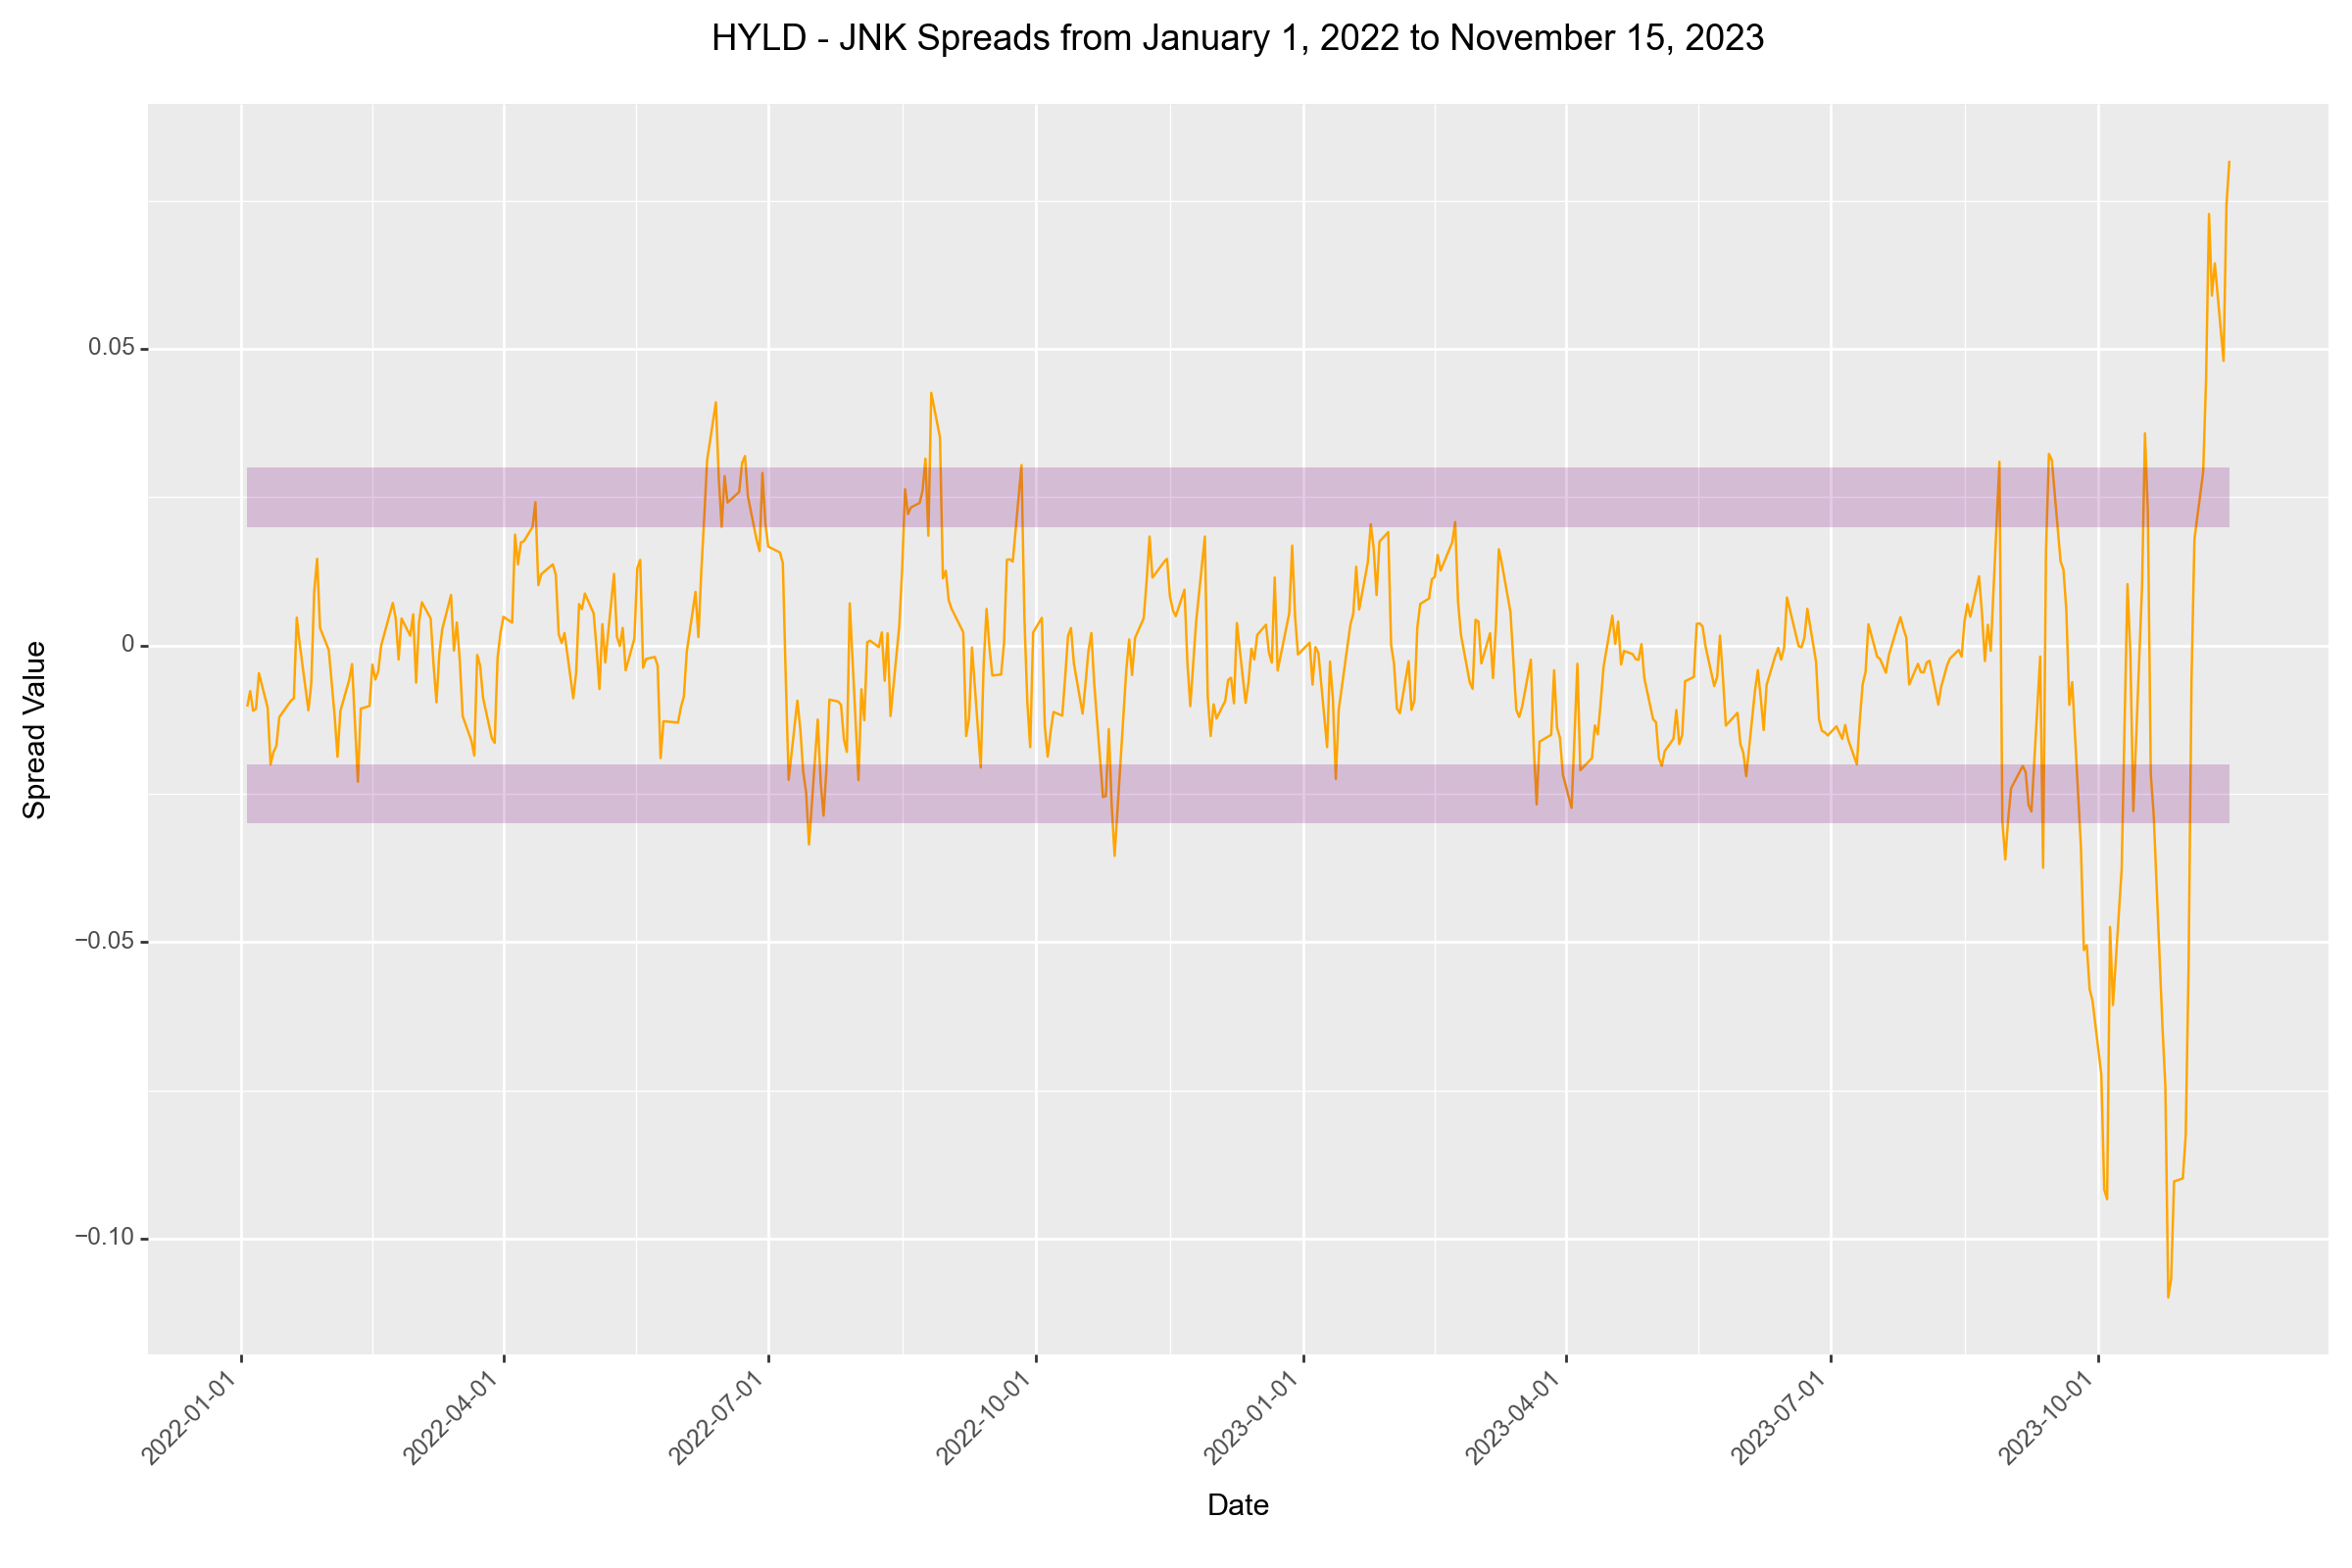

In [111]:
spread_values = srs.spread_data
dates = srs.illiquid_etf['date']

data = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'Spread Value': spread_values
})

base_spread_plot = (
    p9.ggplot(data, p9.aes(x='date', y='Spread Value')) 
    + p9.geom_line(color='orange')
    + p9.geom_ribbon(p9.aes(ymin=-spread_enter_param, ymax=-spread_exit_param), fill='purple', alpha=0.2) 
    + p9.geom_ribbon(p9.aes(ymin=spread_exit_param, ymax=spread_enter_param), fill='purple', alpha=0.2)
    + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    + p9.labs(title='HYLD - JNK Spreads from January 1, 2022 to November 15, 2023',
           x='Date',
           y='Spread Value')
)

base_spread_plot.draw()

#### There appears to be a lot of spread movement towards to middle to end period of 2023. Let us zoom in on the data to see if we notice anything interesting about the results on a closer time scale.

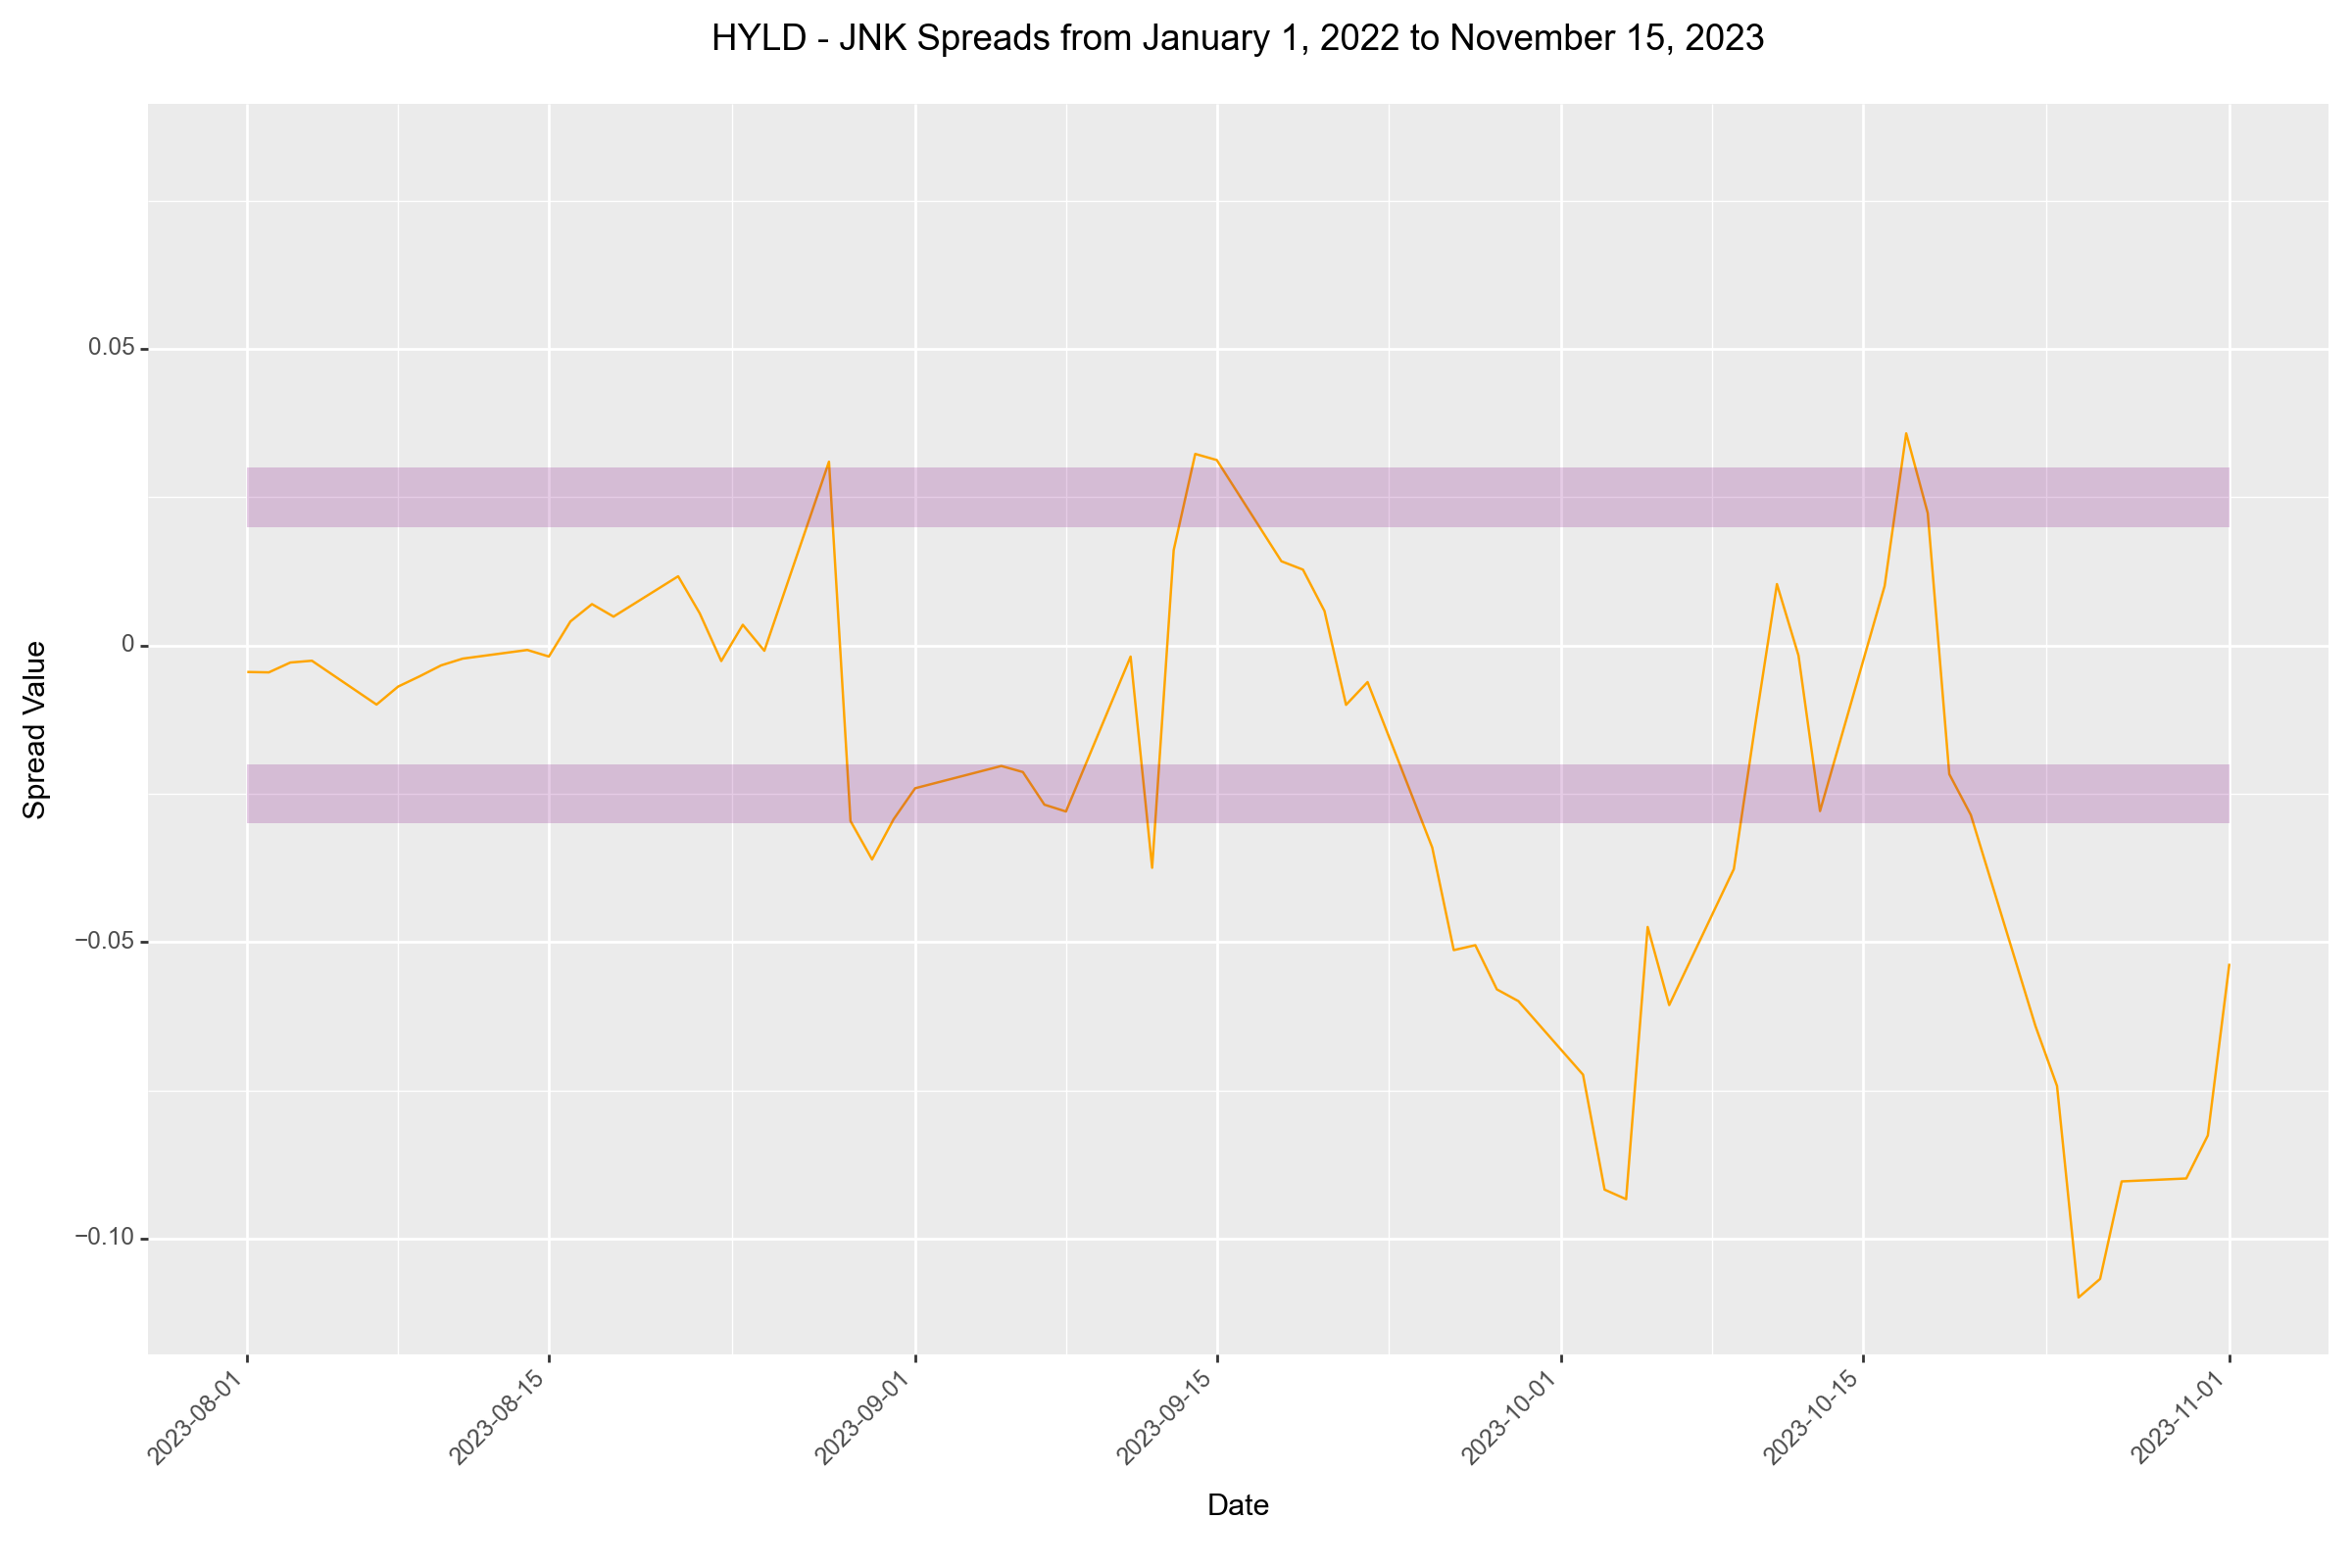

In [112]:
zoomed_spread_plot = (
    p9.ggplot(data, p9.aes(x='date', y='Spread Value')) 
    + p9.geom_line(color='orange')
    + p9.geom_ribbon(p9.aes(ymin=-spread_enter_param, ymax=-spread_exit_param), fill='purple', alpha=0.2) 
    + p9.geom_ribbon(p9.aes(ymin=spread_exit_param, ymax=spread_enter_param), fill='purple', alpha=0.2)
    + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    + p9.labs(title='HYLD - JNK Spreads from January 1, 2022 to November 15, 2023',
           x='Date',
           y='Spread Value')
    + p9.scale_x_datetime(limits=(pd.Timestamp('2023-08-01'), pd.Timestamp('2023-11-01')))
)

zoomed_spread_plot.draw()

#### Like in class, it would be helpful if we had visual indicators of when we entered and exited positions. Let us add dots to denote when we enter, exit, or reverse our positions.

In [113]:
if 'Spread Value' not in trade_log.columns:
    trade_log = trade_log.merge(data, on='date', how='left')

color_map = {
    'none to short': 'red', 'none to long': 'green',
    'long to none': 'red', 'short to none': 'green',
    'long to short': 'red', 'short to long': 'green',
    'short stop loss': 'blue', 'long stop loss': 'blue'
}

size_map = {
    'none to short': 1.5, 'none to long': 1.5,
    'long to none': 1.5, 'short to none': 1.5,
    'long to short': 2.5, 'short to long': 2.5,
    'short stop loss': 2.5, 'long stop loss': 2.5
}

trade_log['Color'] = trade_log['position_change'].map(color_map)
trade_log['Size'] = trade_log['position_change'].map(size_map)

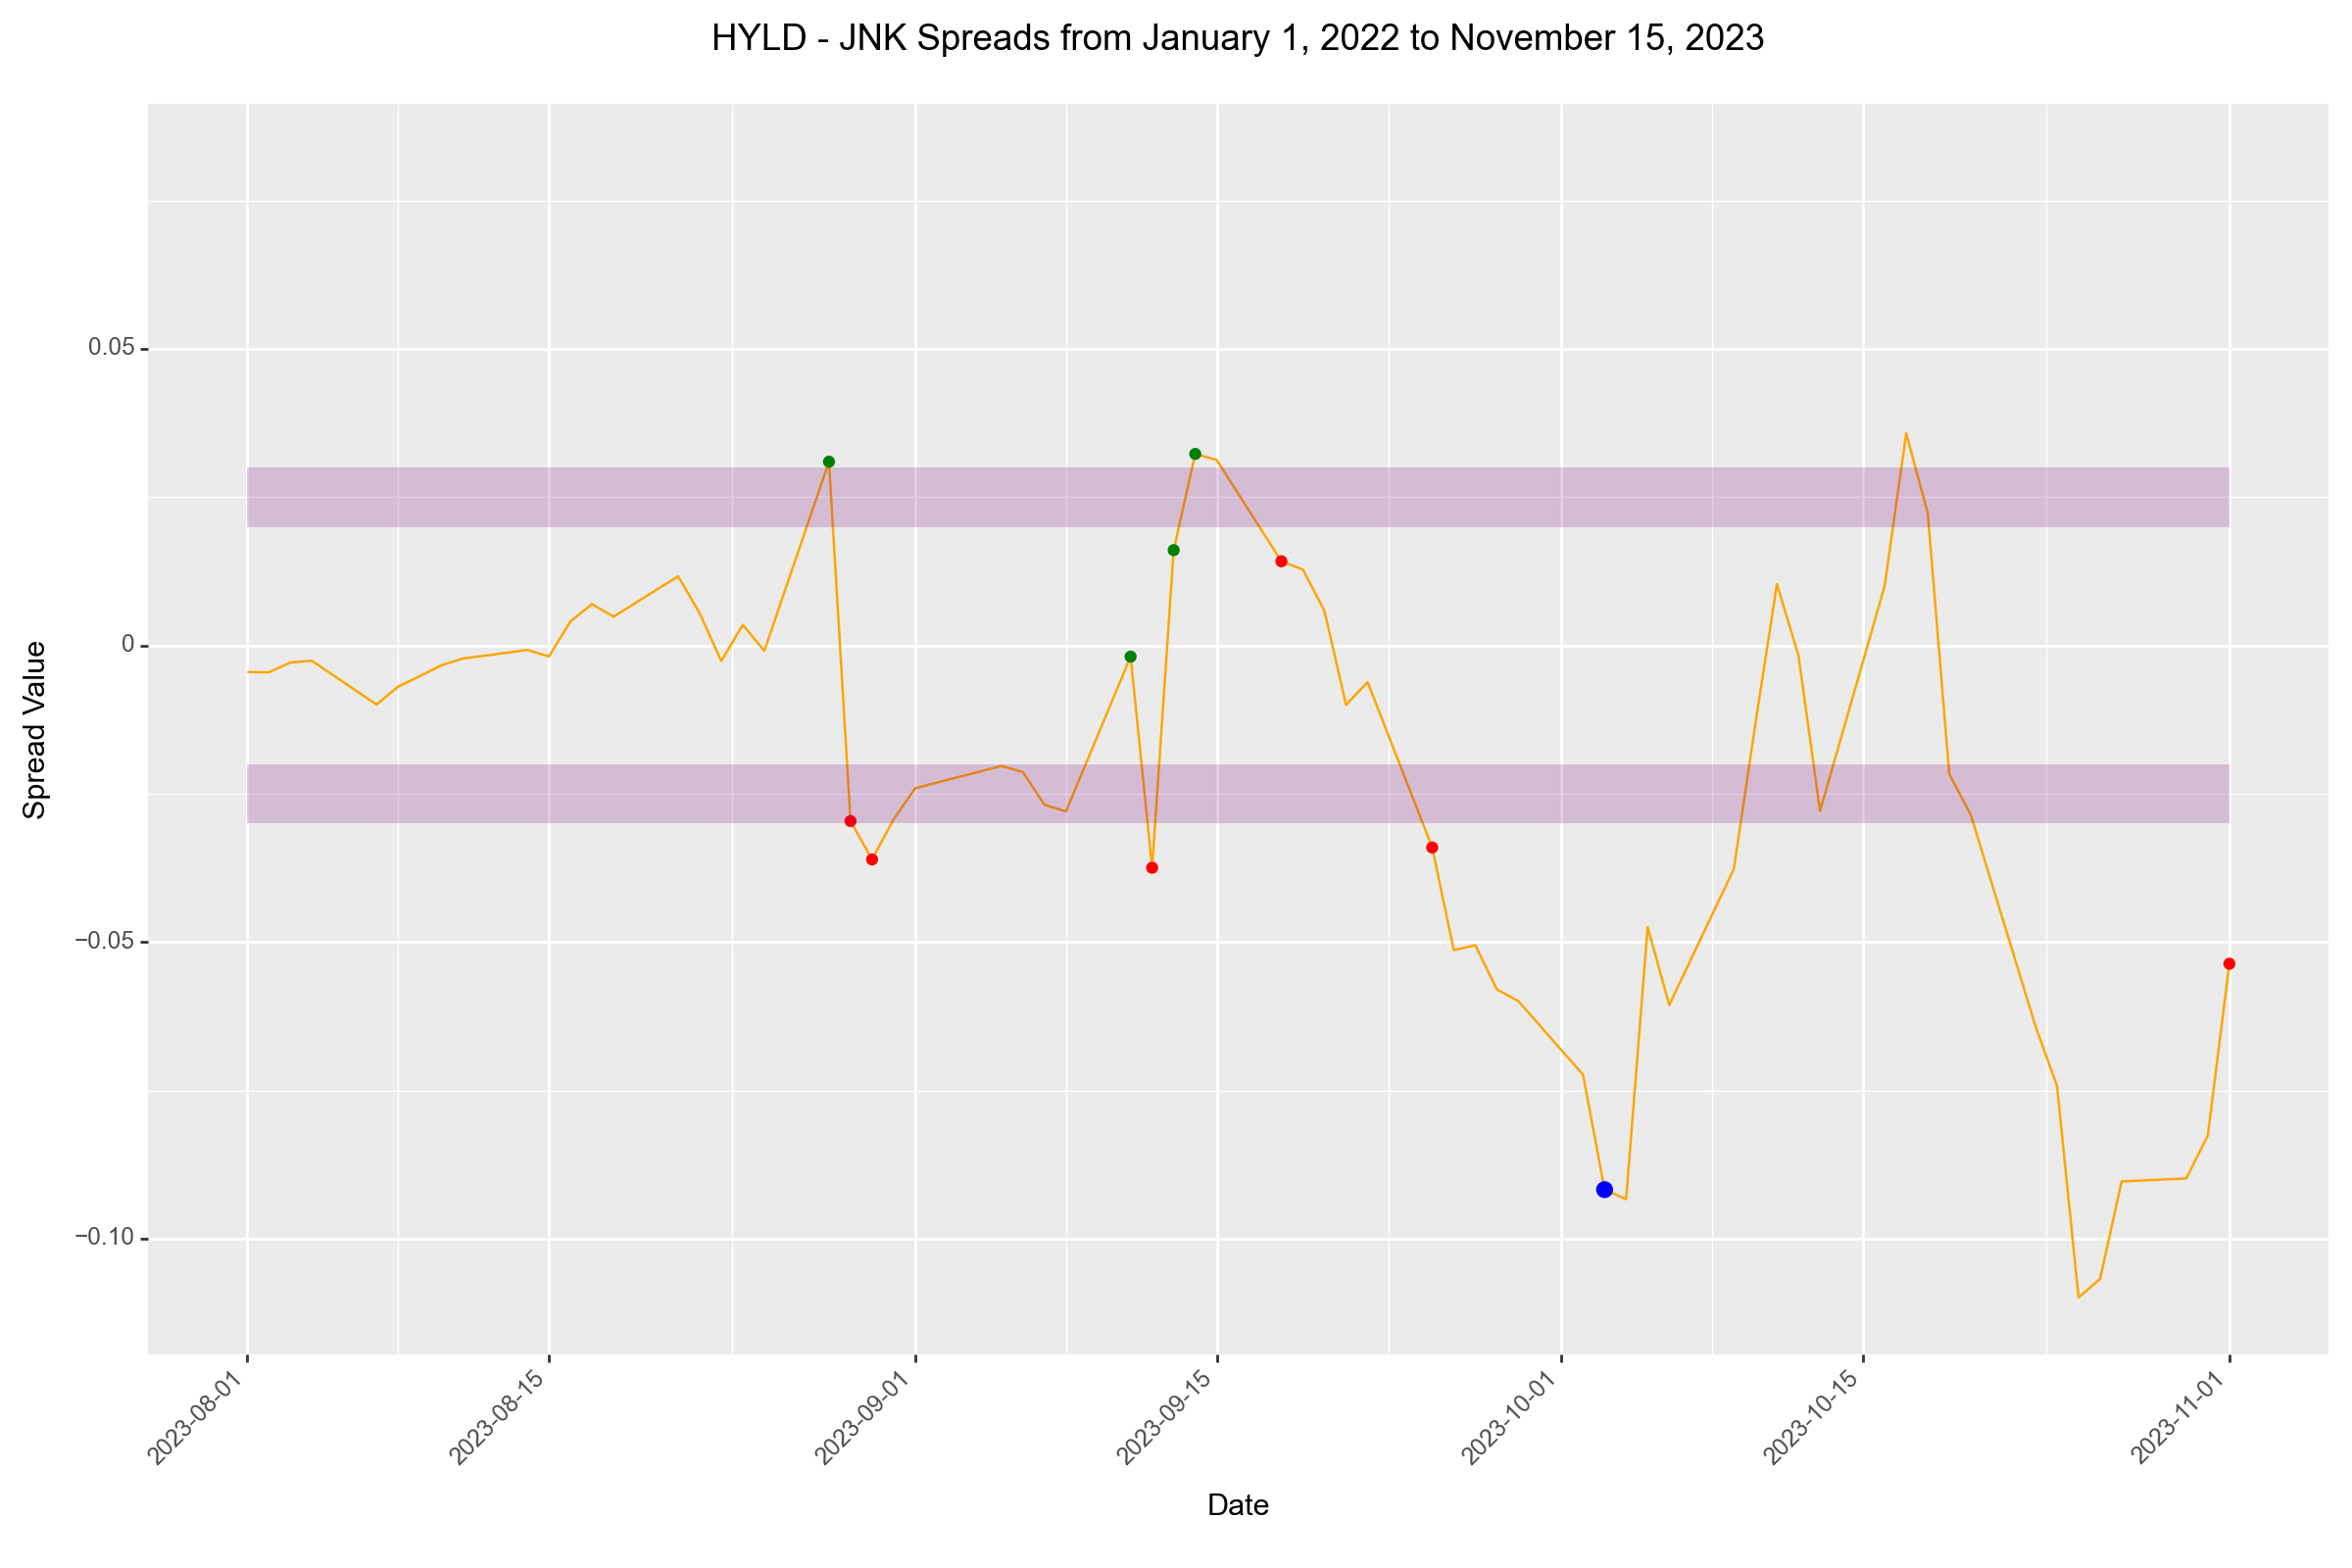

In [114]:
zoomed_spread_plot_with_dots = (
    p9.ggplot(trade_log, p9.aes(x='date', y='Spread Value')) 
    + p9.geom_line(color='orange')
    + p9.geom_point(data=trade_log, 
                    mapping=p9.aes(x='date', y='Spread Value', color='Color', size='Size'), 
                    show_legend=False)
    + p9.geom_ribbon(p9.aes(ymin=-spread_enter_param, ymax=-spread_exit_param), fill='purple', alpha=0.2) 
    + p9.geom_ribbon(p9.aes(ymin=spread_exit_param, ymax=spread_enter_param), fill='purple', alpha=0.2)
    + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    + p9.labs(title='HYLD - JNK Spreads from January 1, 2022 to November 15, 2023',
           x='Date',
           y='Spread Value')
    + p9.scale_size(range=(1.5, 2.5))
    + p9.scale_x_datetime(limits=(pd.Timestamp('2023-08-01'), pd.Timestamp('2023-11-01')))
)

# This line is needed as otherwise the dots are completely opposite colors
zoomed_spread_plot_with_dots += p9.scale_color_identity()
zoomed_spread_plot_with_dots.draw()

#### Our dots function as intended, as we see that all buy orders are green, all sell orders are red, and our stop loss order is blue (to catch the eye and alert the trader of an anomaly). Now that we have visual representations of our spreads and position entries, we will try to find the optimal parameters for maximizing PnL.

In [115]:
# These ranges are somewhat arbitrary, but are based mostly on the spread data seen
# above visualizations to create some sort of reasonable range of values.
spread_exit_param_list = list(np.arange(0.01, 0.031, 0.005))
spread_enter_param_list = list(np.arange(0.02, 0.051, 0.005))
stop_loss_param_list = list(np.arange(0.01, 0.11, 0.01))
trading_cost_param_list = [0, 0.00001]
return_period_param_list = list(np.arange(5, 16, 1))

all_combinations = itertools.product(
    spread_exit_param_list,
    spread_enter_param_list,
    stop_loss_param_list,
    trading_cost_param_list,
    return_period_param_list
)

valid_combinations = [combo for combo in all_combinations if combo[0] < combo[1]]

In [116]:
def find_best_pnl_and_combo(combinations):
    # Check if the data frame already exists
    file_path = 'combinations_pnl_df.csv'
    if os.path.exists(file_path):
        print(f"File '{file_path}' already exists. Loading from file.")
        return pd.read_csv(file_path)
    
    combination_list = []
    for index in range(len(combinations)):
        if index % 1000 == 0:
            print(f'Currently on combination {index} out of {len(combinations)}.')
            
        (spread_exit, 
         spread_enter, 
         stop_loss, 
         trading_cost, 
         return_period) = combinations[index]
        
        spread_strategy = SpreadReversionStrategy(
            [JNK_with_median.reset_index(), HYLD_with_median.reset_index()], 
            illiquid_median_df.reset_index(), 
            spread_trading_start, 
            spread_trading_end, 
            spread_exit, 
            spread_enter, 
            stop_loss, 
            trading_cost, 
            return_period, 
            starting_capital
        )
        spread_strategy.create_spread_trade_log()
        combination_list.append({
            'spread_exit_param': spread_exit, 
            'spread_enter_param': spread_enter, 
            'stop_loss_param': stop_loss, 
            'trading_cost_param': trading_cost, 
            'return_period_param': return_period,
            'cumulative_pnl': spread_strategy.cumulative_pnl
        })
        
    combinations_pnl_df = pd.DataFrame(combination_list)
    combinations_pnl_df.to_csv('combinations_pnl_df.csv')

    return combinations_pnl_df

In [117]:
find_best_pnl_and_combo(valid_combinations)

File 'combinations_pnl_df.csv' already exists. Loading from file.


,Unnamed: 0,spread_exit_param,spread_enter_param,stop_loss_param,trading_cost_param,return_period_param,cumulative_pnl
0,0,0.01,0.02,0.01,0.00000,5,145.770517
1,1,0.01,0.02,0.01,0.00000,6,258.829726
2,2,0.01,0.02,0.01,0.00000,7,343.389746
3,3,0.01,0.02,0.01,0.00000,8,643.089782
4,4,0.01,0.02,0.01,0.00000,9,302.912631
...,...,...,...,...,...,...,...
7035,7035,0.03,0.05,0.10,0.00001,11,-11.166991
7036,7036,0.03,0.05,0.10,0.00001,12,26.347313
7037,7037,0.03,0.05,0.10,0.00001,13,-12.456855
7038,7038,0.03,0.05,0.10,0.00001,14,8.781791


In [118]:
cumulative_pnl_df_with_params = find_best_pnl_and_combo(valid_combinations)
max_pnl_row = (cumulative_pnl_df_with_params.loc
                [cumulative_pnl_df_with_params['cumulative_pnl'].idxmax()])

cumulative_pnl_df_with_trade_cost = (cumulative_pnl_df_with_params
                                    [cumulative_pnl_df_with_params['trading_cost_param'] == 0.00001])
max_pnl_row_with_trading_cost = (cumulative_pnl_df_with_trade_cost.loc
                                [cumulative_pnl_df_with_trade_cost['cumulative_pnl'].idxmax()])

display(max_pnl_row)
display(max_pnl_row_with_trading_cost)

File 'combinations_pnl_df.csv' already exists. Loading from file.


Unnamed: 0              69.000000
spread_exit_param        0.010000
spread_enter_param       0.020000
stop_loss_param          0.040000
trading_cost_param       0.000000
return_period_param      8.000000
cumulative_pnl         698.485835
Name: 69, dtype: float64

Unnamed: 0              80.000000
spread_exit_param        0.010000
spread_enter_param       0.020000
stop_loss_param          0.040000
trading_cost_param       0.000010
return_period_param      8.000000
cumulative_pnl         696.184984
Name: 80, dtype: float64

#### We see that in both the case where we have no trade cost and where we have a small trade cost, our optimal parameters are the same. Therefore, we will use these specified parameters for the remainder of the analysis. Let us then create a spread strategy using these parameters to test correlations. Also note that a larger stop loss parameter will result in the same cumulative PnL value for this sample data, but we will choose the smallest possible stop loss that yields this maximum PnL.

In [119]:
(combination_number, 
optimal_spread_exit_param, 
optimal_spread_enter_param, 
optimal_stop_loss_param, 
optimal_trading_cost_param, 
optimal_return_period_param, 
optimal_cumulative_pnl) = max_pnl_row

# Need to make the return period an integer, as otherwise it cannot be used to slice indices
optimal_return_period_param = int(optimal_return_period_param)

In [120]:
# Create the optimal spread strategy given the optimal parameters from before
optimal_spread_strategy = SpreadReversionStrategy(
    [JNK_with_median.reset_index(), HYLD_with_median.reset_index()], 
    illiquid_median_df.reset_index(), 
    spread_trading_start, 
    spread_trading_end, 
    optimal_spread_exit_param, 
    optimal_spread_enter_param, 
    optimal_stop_loss_param, 
    optimal_trading_cost_param, 
    optimal_return_period_param,
    starting_capital
)

optimal_trade_log = optimal_spread_strategy.create_spread_trade_log()
optimal_trade_log['date'] = pd.to_datetime(optimal_trade_log['date'])
optimal_trade_log

,date,position_change,long_position_amount,short_position_amount,daily_pnl,cumulative_pnl,capital
0,2022-01-03,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
1,2022-01-04,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
2,2022-01-05,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
3,2022-01-06,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
4,2022-01-07,none,0.000000,0.0000,0.000000,0.000000,1.697290e+06
...,...,...,...,...,...,...,...
466,2023-11-09,staying long,1874.323528,1883.2617,26.142423,807.414413,1.697826e+06
467,2023-11-10,staying long,1883.876867,1900.7498,-7.934761,799.479652,1.697826e+06
468,2023-11-13,staying long,1880.553967,1894.0268,3.400100,802.879752,1.697826e+06
469,2023-11-14,staying long,1899.868326,1990.0495,-76.708341,726.171411,1.697826e+06


#### Now that we have an optimal trading log, we will plot the spread values and visualize the strategy in a way similar to class.

In [121]:
optimal_spread_values = optimal_spread_strategy.spread_data
dates = optimal_trade_log['date']

optimal_spread_data = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'Spread Value': optimal_spread_values
})

if 'Spread Value' not in optimal_trade_log.columns:
    optimal_trade_log = optimal_trade_log.merge(optimal_spread_data, on='date', how='left')
    
optimal_trade_log['Color'] = optimal_trade_log['position_change'].map(color_map)
optimal_trade_log['Size'] = optimal_trade_log['position_change'].map(size_map)

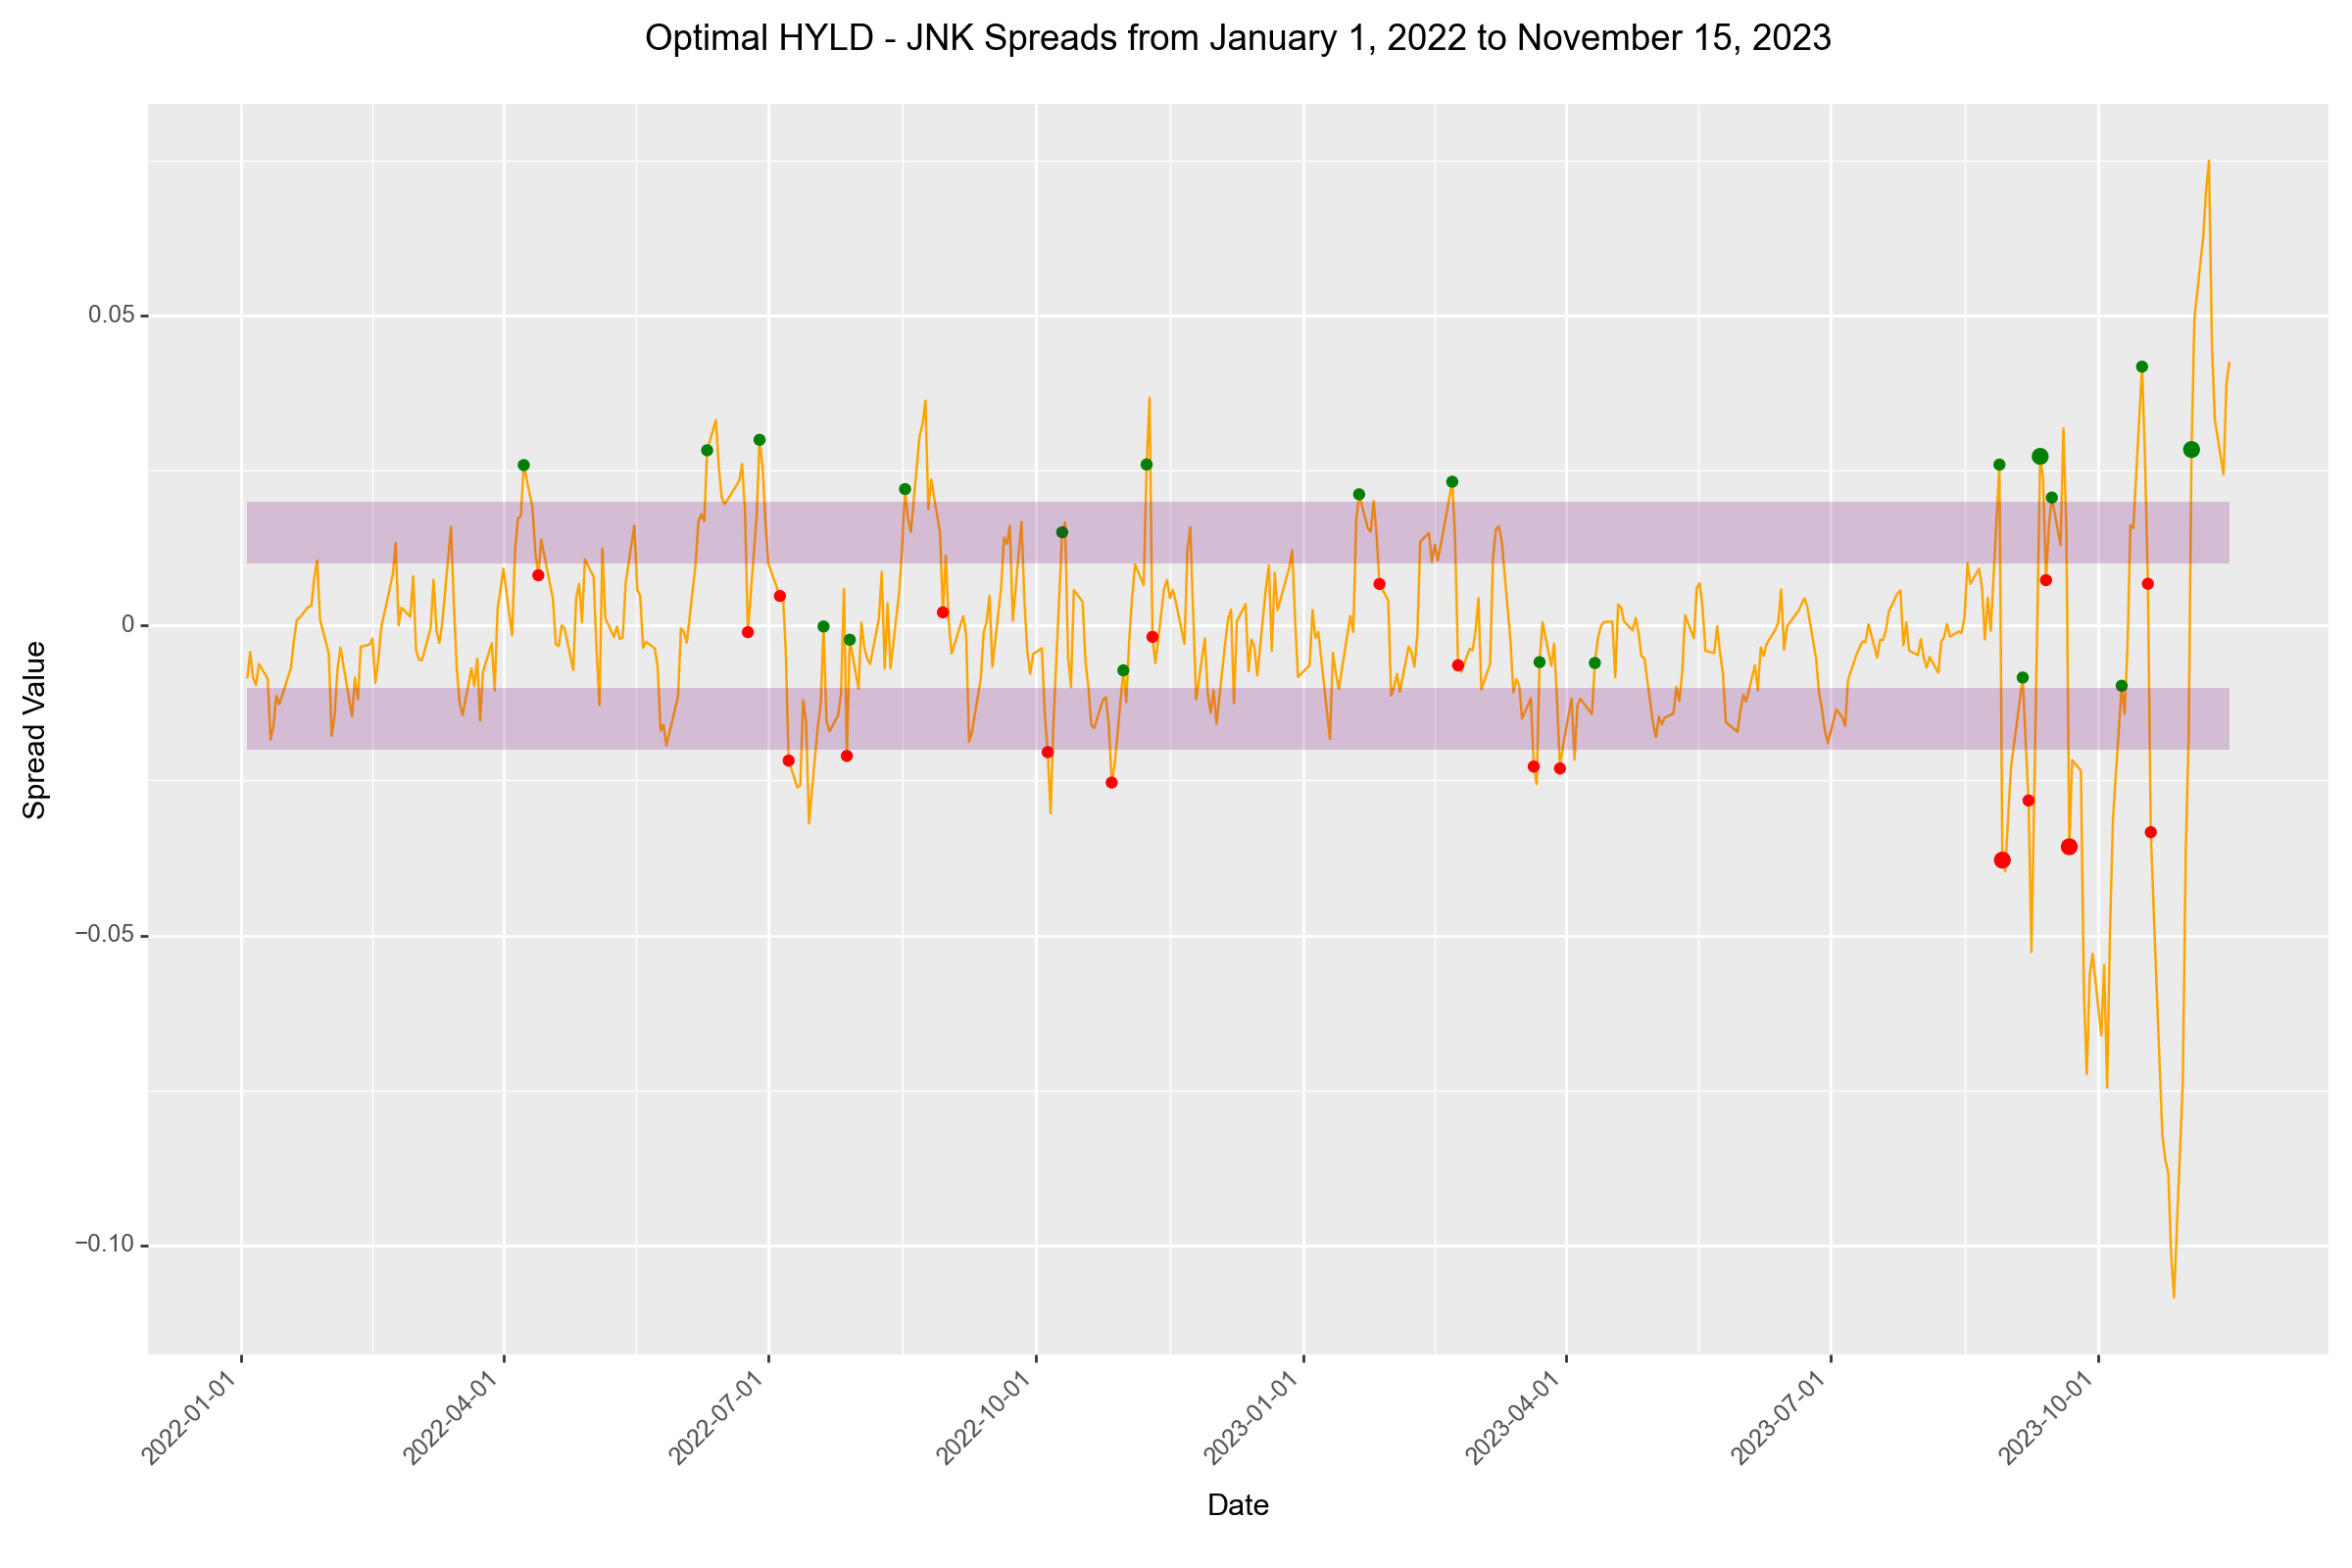

In [122]:
optimal_spread_plot_with_dots = (
    p9.ggplot(optimal_trade_log, p9.aes(x='date', y='Spread Value')) 
    + p9.geom_line(color='orange')
    + p9.geom_point(data=optimal_trade_log, 
                    mapping=p9.aes(x='date', y='Spread Value', color='Color', size='Size'), 
                    show_legend=False)
    + p9.geom_ribbon(p9.aes(ymin=-optimal_spread_enter_param, 
                            ymax=-optimal_spread_exit_param), 
                            fill='purple', 
                            alpha=0.2) 
    + p9.geom_ribbon(p9.aes(ymin=optimal_spread_exit_param, 
                            ymax=optimal_spread_enter_param), 
                            fill='purple', 
                            alpha=0.2)
    + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    + p9.labs(title='Optimal HYLD - JNK Spreads from January 1, 2022 to November 15, 2023',
           x='Date',
           y='Spread Value')
    + p9.scale_size(range=(1.5, 2.5))
)

# This line is needed as otherwise the dots are completely opposite colors
optimal_spread_plot_with_dots += p9.scale_color_identity()
optimal_spread_plot_with_dots.draw()

#### Our plot works as intended, mapping big dots to complete reversals of the strategy and mapping the colors to their associated action (i.e buys are green and shorts are red). With the optimal trading strategy working as intended, we now look to correlations to Fama French and SVOL levels for the same period.

In [123]:
if 'date' not in fama_french_data.columns:
    fama_french_data = fama_french_data.reset_index()
    
if 'date' not in sorted_SVOL_data.columns:
    sorted_SVOL_data = sorted_SVOL_data.reset_index()
    
fama_french_date_aligned_df = (fama_french_data
                                [(fama_french_data['date'] >= spread_trading_start) & 
                                 (fama_french_data['date'] <= spread_trading_end)])
fama_french_date_aligned_df = pd.merge(optimal_trade_log['date'], 
                                       fama_french_date_aligned_df, 
                                       on='date', how='inner')

SVOL_date_aligned_df = (sorted_SVOL_data
                        [(sorted_SVOL_data['date'] >= spread_trading_start) & 
                        (sorted_SVOL_data['date'] <= spread_trading_end)].reset_index()
                        .drop('index', axis=1))

In [124]:
mkt_factor = fama_french_date_aligned_df['Mkt-RF']
size_factor = fama_french_date_aligned_df['SMB']
value_factor = fama_french_date_aligned_df['HML']
optimal_spread_df = pd.DataFrame(optimal_spread_values, columns=['spread_value'])

In [125]:
mkt_to_spread_corr = mkt_factor.corr(optimal_spread_df['spread_value'])
size_to_spread_corr = size_factor.corr(optimal_spread_df['spread_value'])
value_to_spread_corr = value_factor.corr(optimal_spread_df['spread_value'])

(
    f'The correlation between the spreads and market factor is {mkt_to_spread_corr}.',
    f'The correlation between the spreads and size factor is {size_to_spread_corr}.',
    f'The correlation between the spreads and value factor is {value_to_spread_corr}.'
 )

('The correlation between the spreads and market factor is -0.08777172244866459.',
 'The correlation between the spreads and size factor is -0.011522875849949125.',
 'The correlation between the spreads and value factor is 0.05113176781658465.')

#### The correlations between the spreads from our optimal strategy and the Fama French factors are very low, which could indicate a diversification opportunity for a future portfolio. Because of these promising correlations, let us see if the running N-period correlations between the factors also produces favorable diversification results. After we have the rolling correlations, let us create a heatmap of the pairwise correlations between the spread correlations and the factor returns.

In [126]:
window_size = 15

rolling_mkt_to_spread_corr = (mkt_factor.rolling(window=window_size)
                              .corr(optimal_spread_df['spread_value']).dropna())

rolling_size_to_spread_corr = (size_factor.rolling(window=window_size)
                              .corr(optimal_spread_df['spread_value']).dropna())

rolling_value_to_spread_corr = (value_factor.rolling(window=window_size)
                              .corr(optimal_spread_df['spread_value']).dropna())

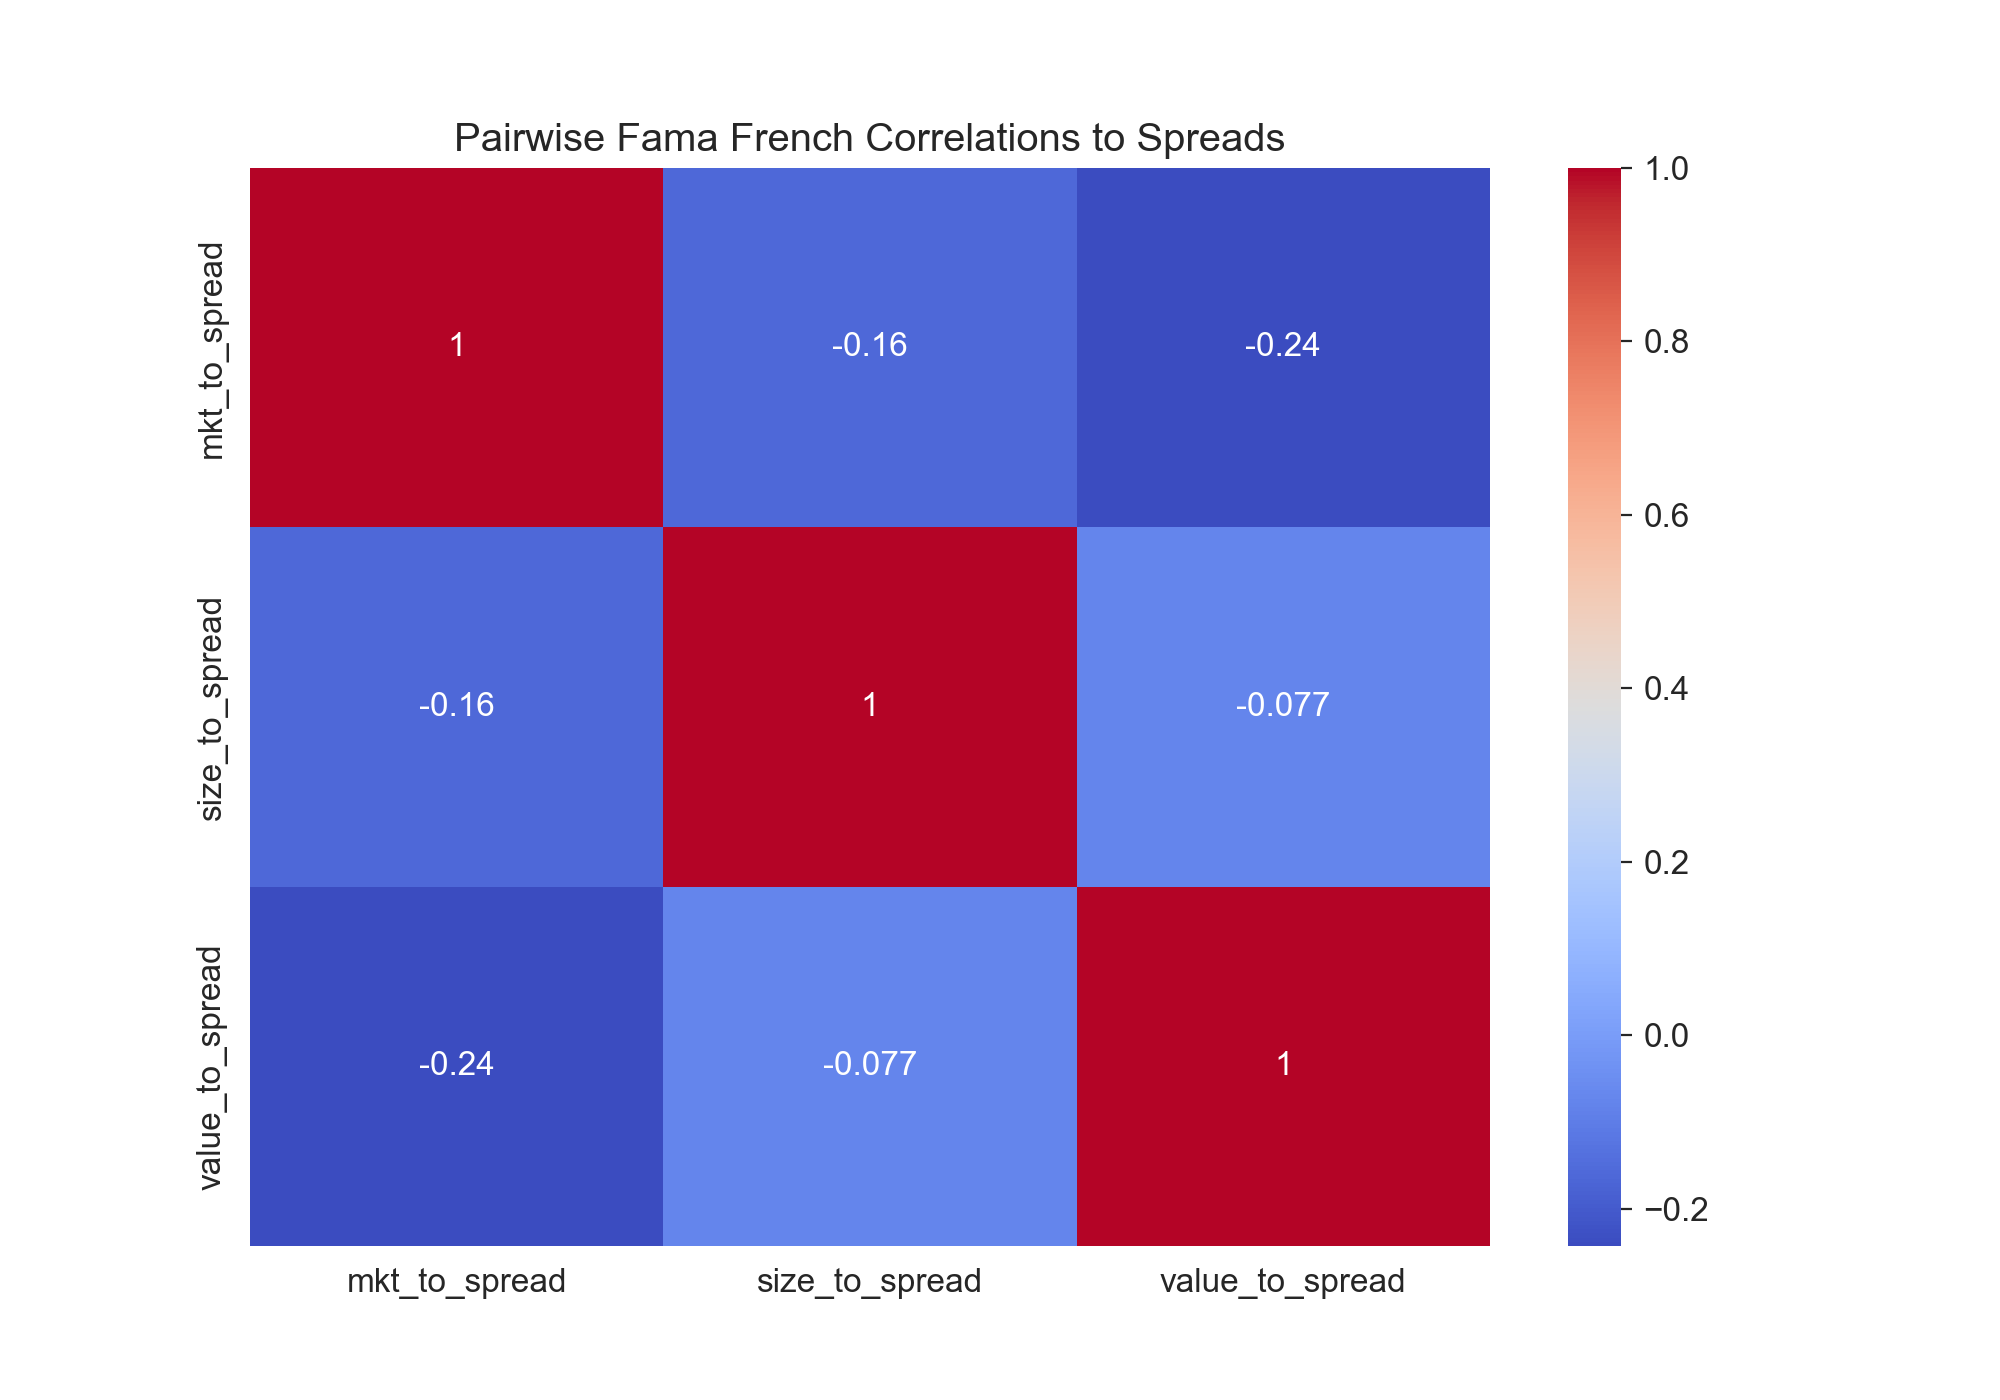

In [127]:
fama_french_corr_df = pd.DataFrame({'mkt_to_spread': rolling_mkt_to_spread_corr, 
                                    'size_to_spread': rolling_size_to_spread_corr, 
                                    'value_to_spread': rolling_value_to_spread_corr})

fama_french_corr_matrix = fama_french_corr_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(fama_french_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Pairwise Fama French Correlations to Spreads')
plt.show()

#### From the heat map, we see that there is a low, negative correlation between the series of running correlations between the factor returns and spread values. In essence, this means that the factors do not move in tandem with how they correlate with the spread values, indicating that the factor returns do not move similarly with respect to the spread values. This further validates our assessment that utilizing the Fama French factors could be beneficial to diversification. Let us now plot the three series of correlations and see if they appear roughly consistent over time (and thus these pairwise correlations are not the product of anomalies).

In [128]:
def plot_correlation_series(corr_dates, correlations, factor_name, corr_var='Spread'):
    """
    Plots a correlation series against dates using plotnine.
    """
    corr_data = pd.DataFrame({'Date': corr_dates, 'Correlation': correlations})
    title = f'{factor_name} to {corr_var} Correlation Over Time'

    # Plot
    plot = (
        p9.ggplot(corr_data, aes(x='Date', y='Correlation')) 
        + p9.geom_line(color='blue')
        + p9.labs(title=title, x='Date', y='Correlation')
        + p9.theme(figure_size=(10, 6), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

    return plot

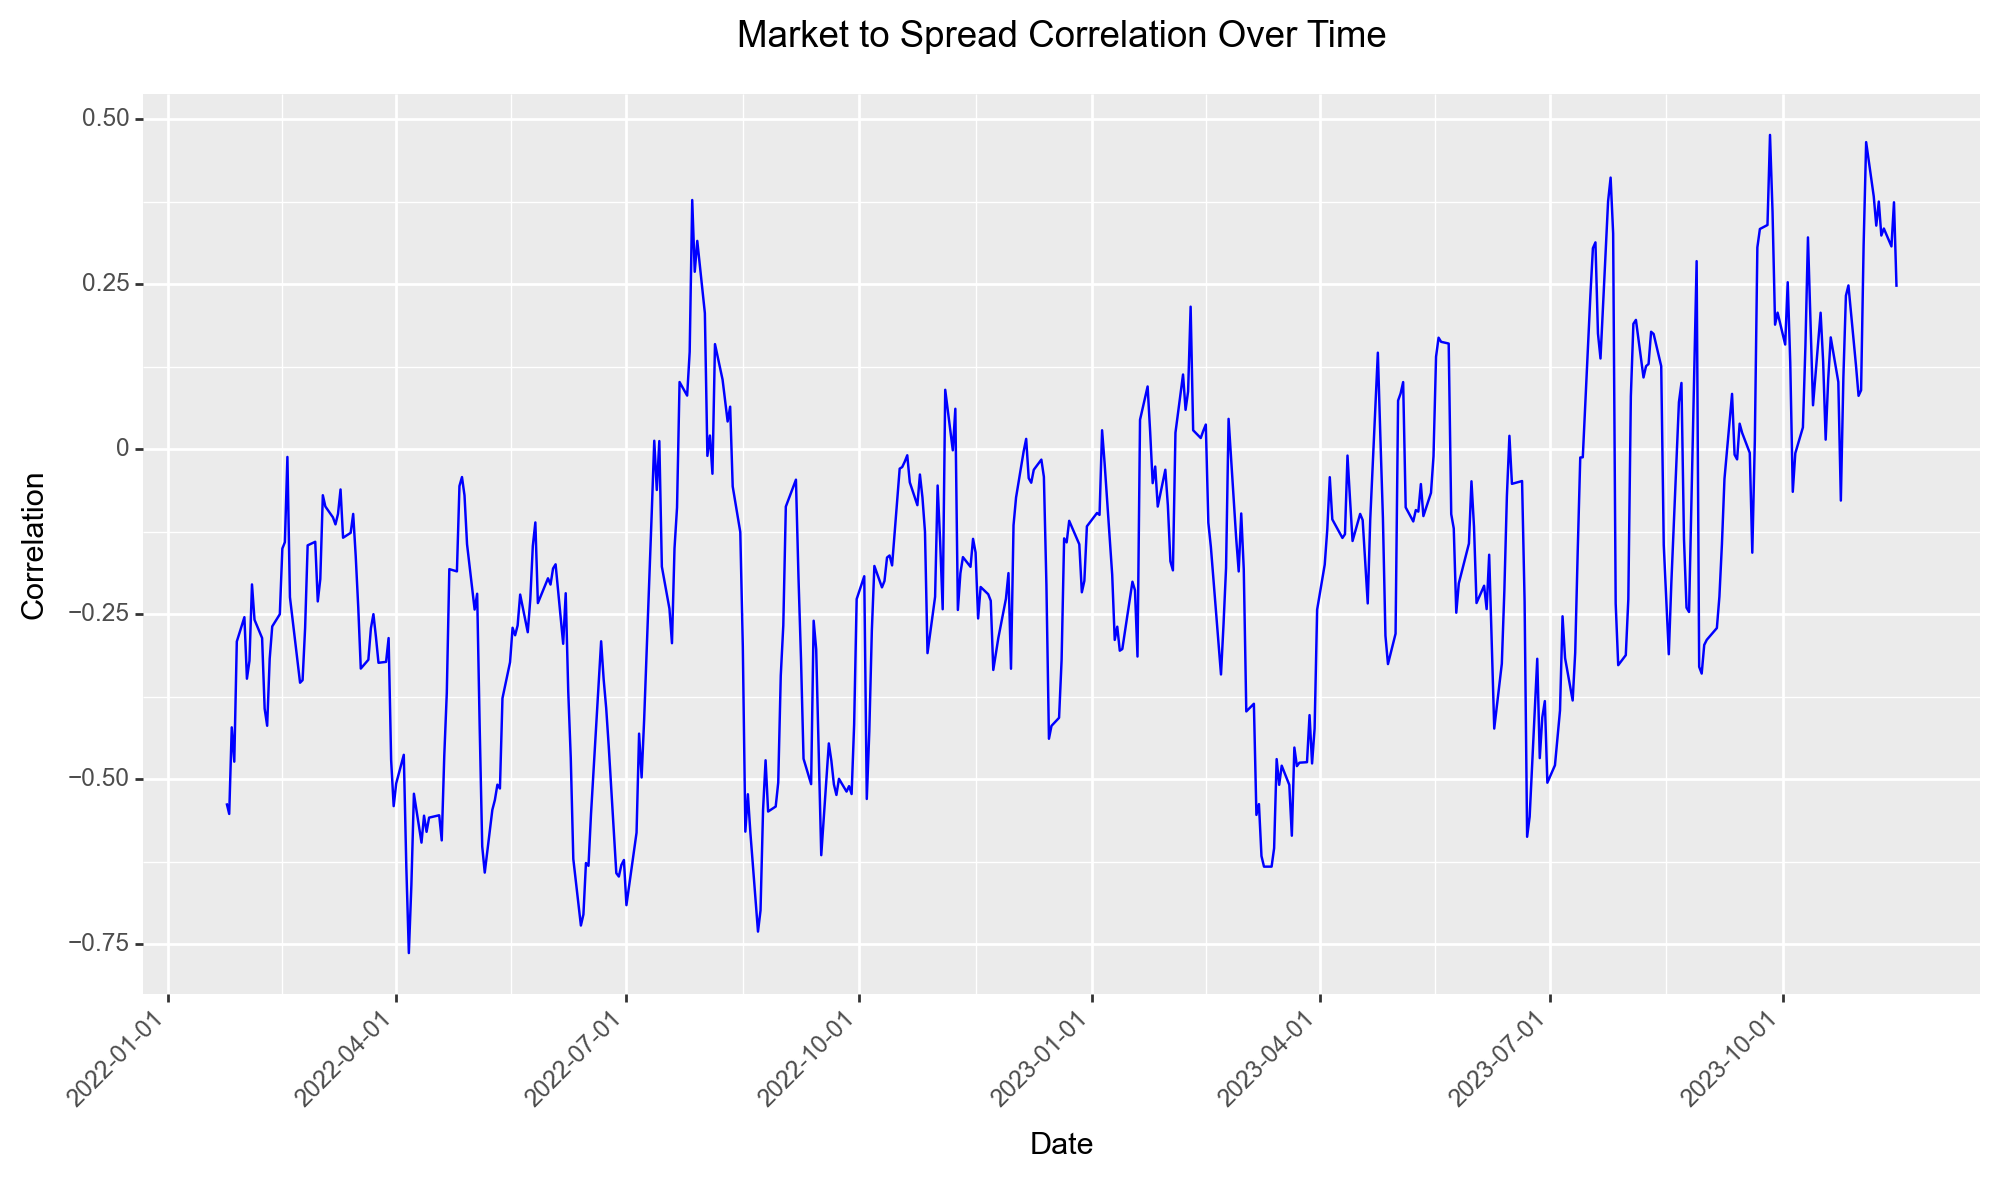

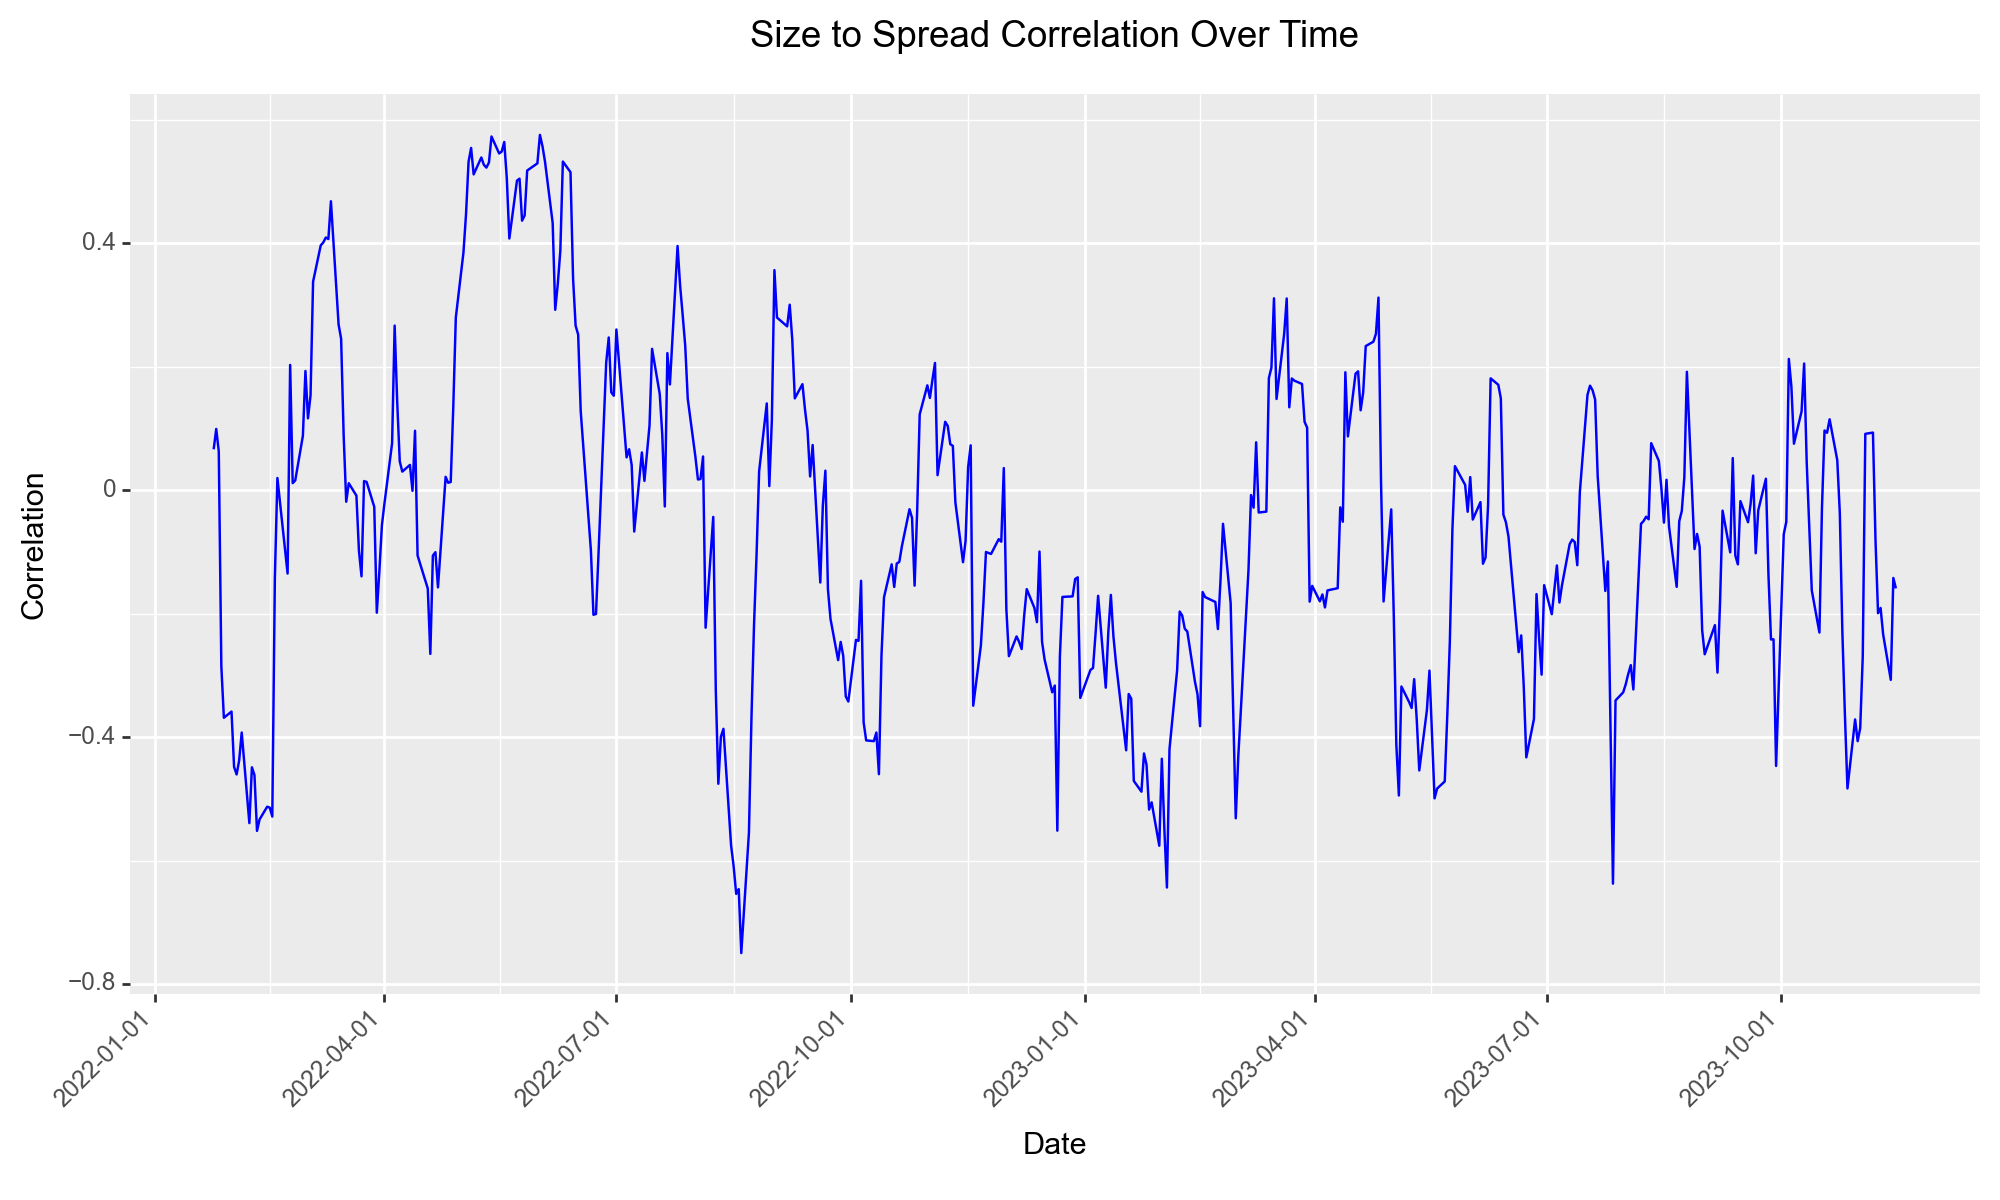

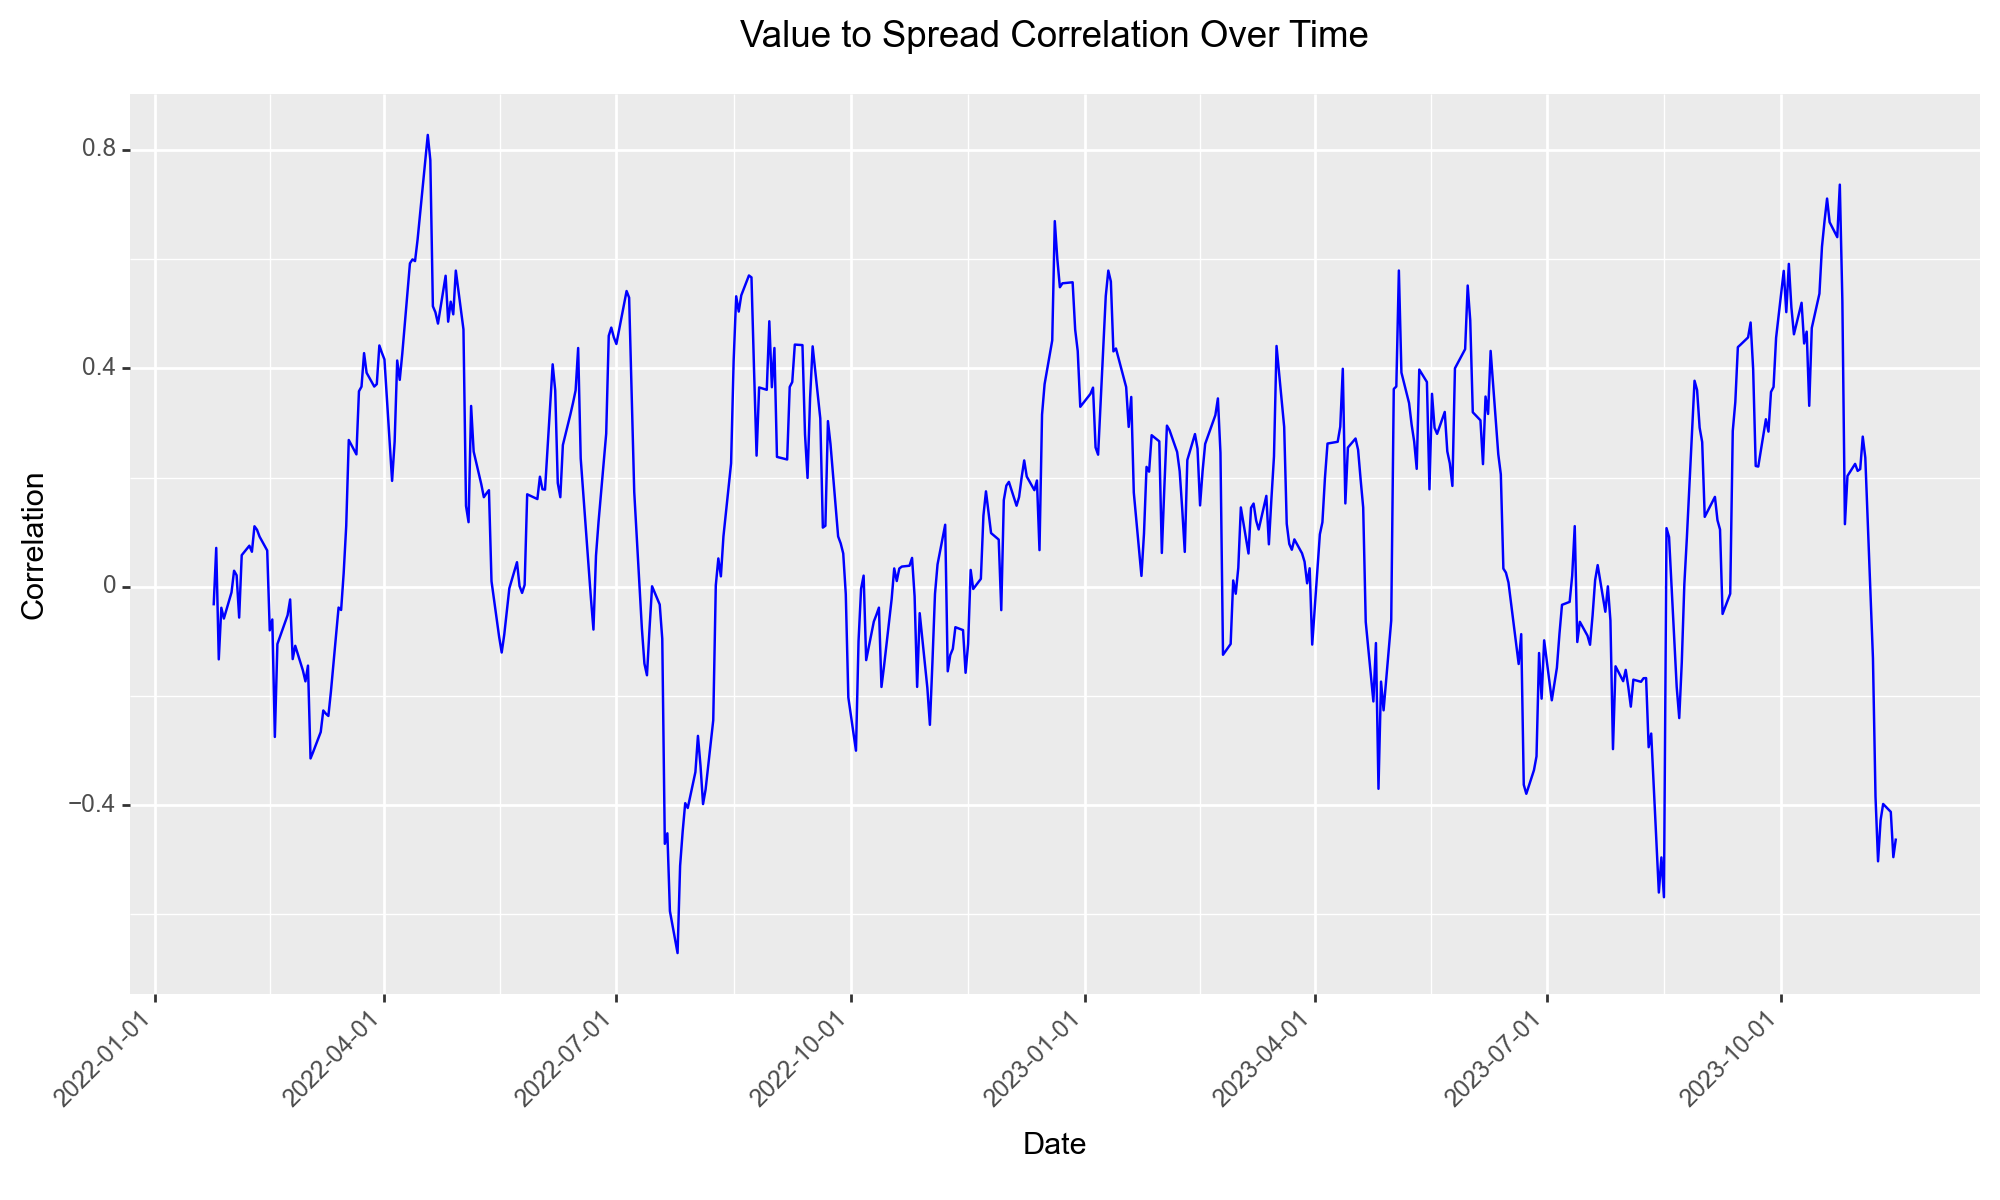

In [129]:
rolling_corr_dates = optimal_trade_log['date'].iloc[window_size-1:]

mkt_to_spread_plot = plot_correlation_series(rolling_corr_dates, rolling_mkt_to_spread_corr, 'Market')
display(mkt_to_spread_plot.draw())

size_to_spread_plot = plot_correlation_series(rolling_corr_dates, rolling_size_to_spread_corr, 'Size')
display(size_to_spread_plot.draw())

value_to_spread_plot = plot_correlation_series(rolling_corr_dates, rolling_value_to_spread_corr, 'Value')
display(value_to_spread_plot.draw())

#### The running correlations definitely appear to be volatile, but this does not necessarily indicate that the Fama French factors would be a bad addition to a new trading strategy alongside the spread. Further analysis would be needed.

#### Now that we have analyzed the spread values against the factor returns, let us look to see how the spread values and pnl correlate to the SVOL adjusted close prices.

In [130]:
svol_to_spread_corr = (sorted_SVOL_data['adj_close']
                       .corr(optimal_spread_df['spread_value']))

svol_to_pnl_corr = (sorted_SVOL_data['adj_close']
                    .corr(optimal_trade_log['cumulative_pnl']))

svol_to_spread_corr, svol_to_pnl_corr

(-0.09850877442127051, 0.08442168881234269)

#### Interestingly, we have a low correlation between the SVOL closing prices and the spread values/cumulative PnL. To explore further, let us take a running correlation and plot like we did with the factor returns.

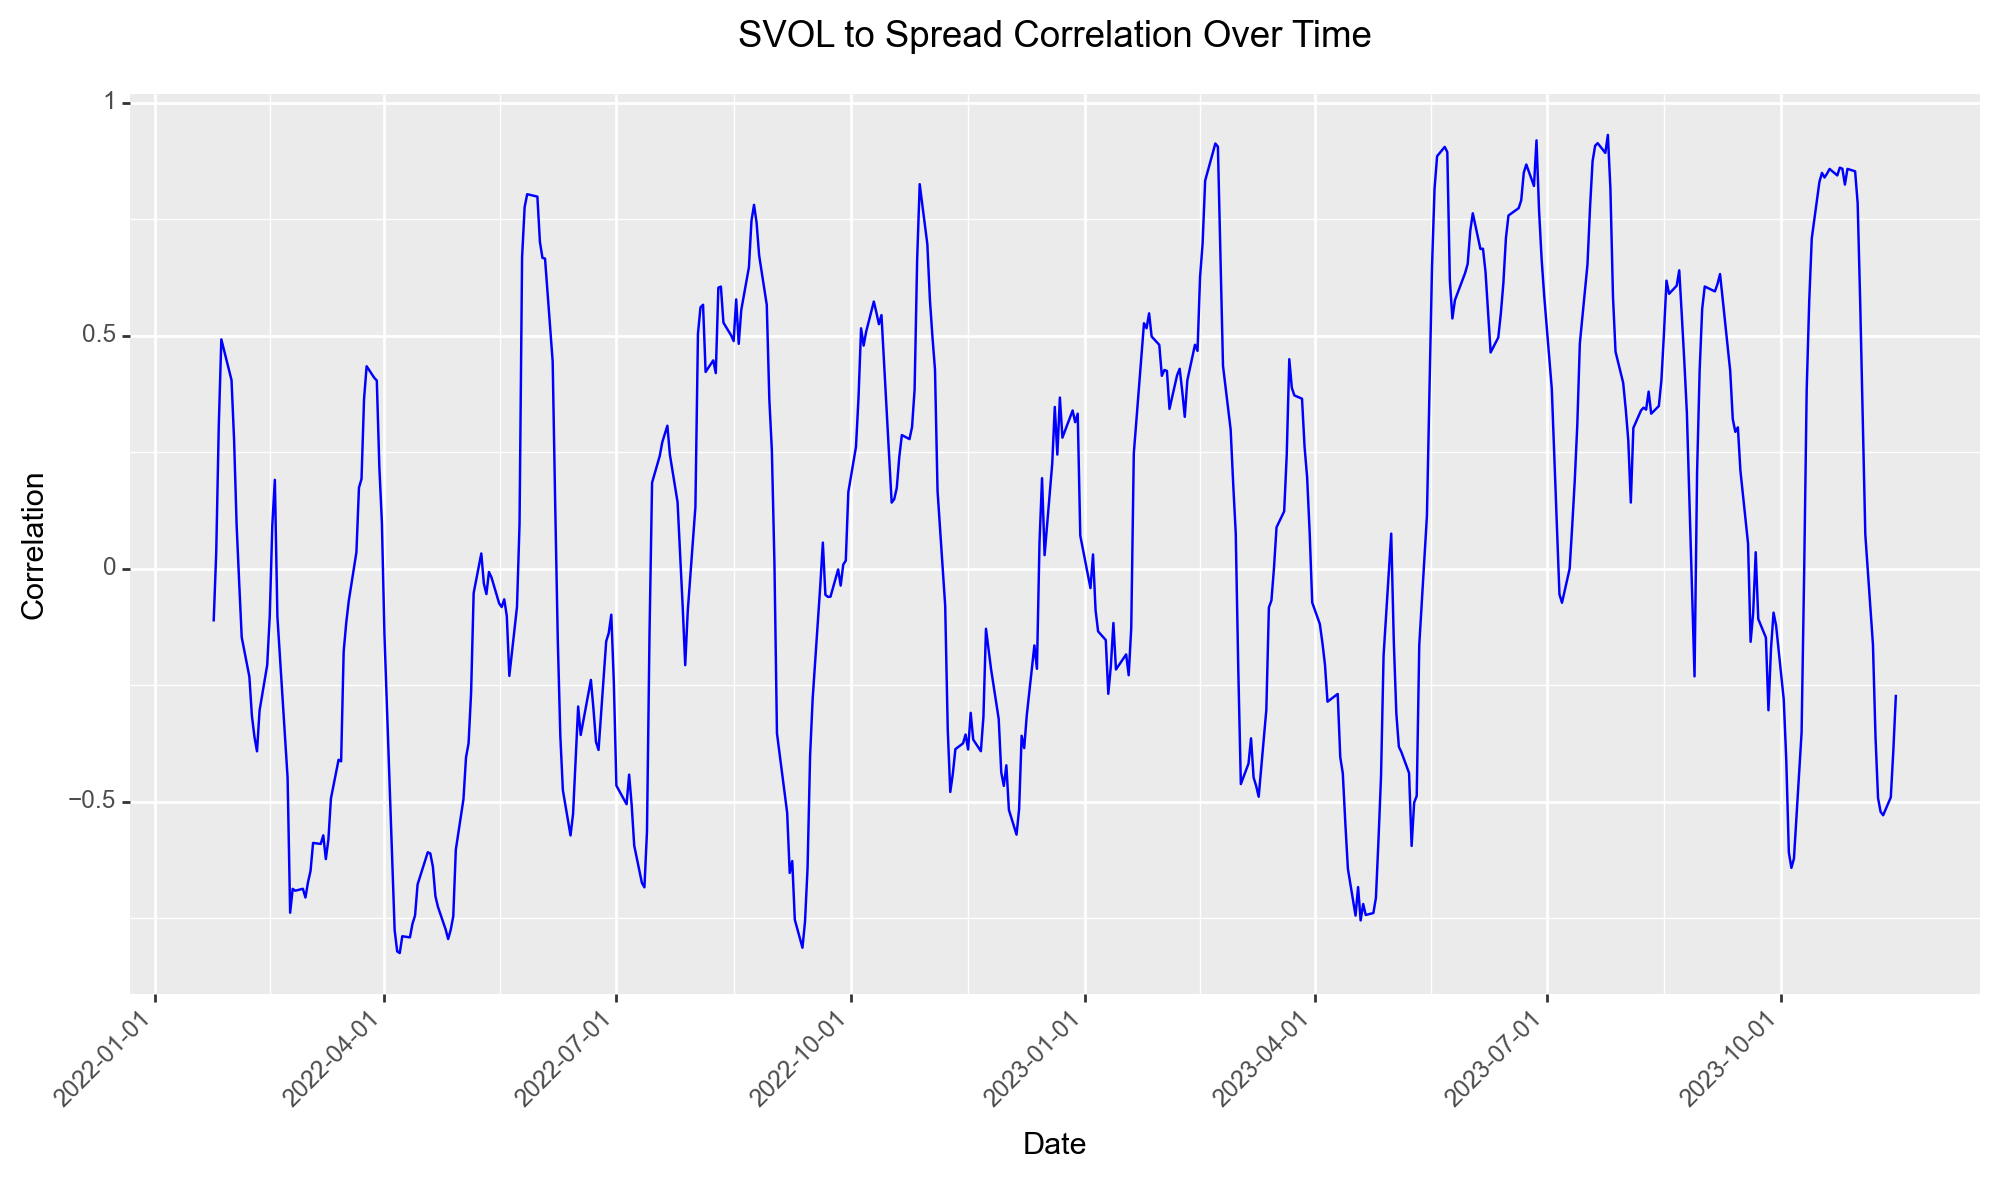

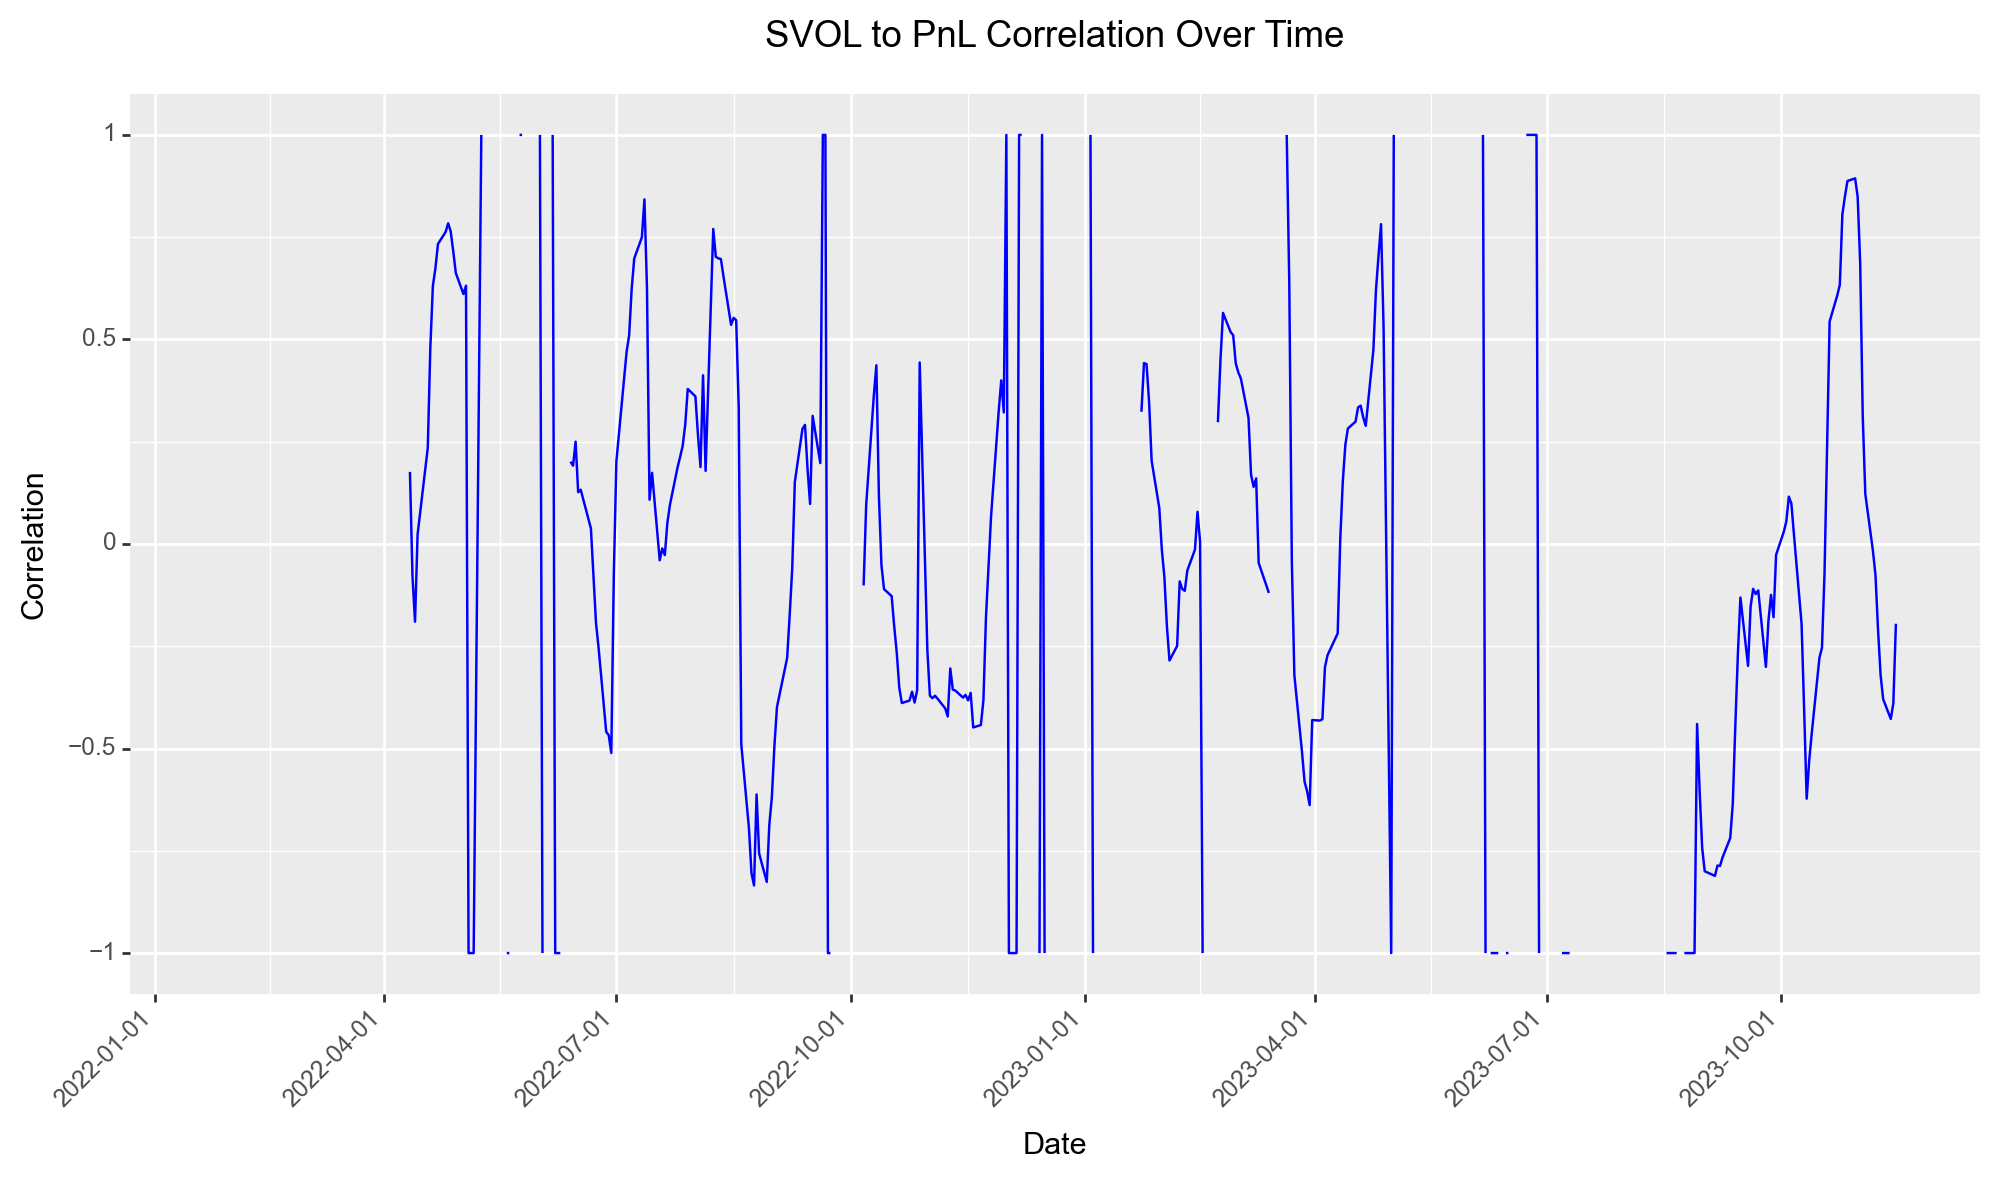

In [131]:
rolling_svol_to_spread_corr = (sorted_SVOL_data['adj_close']
                               .rolling(window=window_size)
                               .corr(optimal_spread_df['spread_value']).dropna())

rolling_svol_to_pnl_corr = (sorted_SVOL_data['adj_close']
                            .rolling(window=window_size)
                            .corr(optimal_trade_log['cumulative_pnl']).dropna())
rolling_svol_to_pnl_corr.replace([np.inf, -np.inf], [1, -1], inplace=True)

svol_to_spread_plot = plot_correlation_series(rolling_corr_dates, rolling_svol_to_spread_corr, 'SVOL')
display(svol_to_spread_plot.draw())

svol_to_pnl_plot = plot_correlation_series(rolling_corr_dates, rolling_svol_to_pnl_corr, 'SVOL', 'PnL')
display(svol_to_pnl_plot.draw())

#### For some reason, the rolling correlation between the SVOL prices and PnL hits values of inf and -inf. After extensive testing, I do not understand what is wrong since the correlation function is not my own. I have decided to make all values of inf = 1 and -inf = -1 to at least create a reasonable plot. However, what we can notice when we look between the two plots is that the SVOL to PnL correlation hits 1, the correlation between SVOL and spreads is highly positive, and similarly when the SVOL to PnL correlation hits -1, the correlation between SVOL and spreads is highly negative. This is interesting to discover because it implies that periods of high correlation between SVOL and our ETF spread (HYLD - JNK) result in a high correlation between SVOL and our spread PnL. Future strategies could attempt to take advantage of this relationship by trading the spread during high correlation periods between SVOL and spread values. 

## Conclusion: After implementing a spread reversion strategy, finding optimal parameters, and analyzing correlations of the optimal trading strategy to exogenous factors, a few important revelations arise which lead way to future analysis and strategy ideas:

### What was learned
#### 1. The PnL of a spread strategy varies drastically depending on the input parameters. Looking at our optimal_trading_log, we see that our ability to produce profits was dependent on our ability to trade (i.e. lower entry trade level), but also dependent on our ability to exit the position (smaller difference between entry and exit). PnL can work against you if you refuse to trade out of a spread in the same way you will fail to capture small wins if the spread is never entered.
#### 2. The Fama French factors appear to have a low correlation to the spread values and could be useful for diversification purposes. However, we would need to backtest a portfolio strategy on a rolling basis, as we saw large fluctuations in the correlations between the spread values and factor returns. We would want to ensure that our strategy was robust and provided actual benefit on a rolling time-series basis.
#### 3. Spread values and PnL have low correlation to SVOL levels over our trading period, but have volatile, almost periodic rolling correlations between the two. When spread values are in a period of high correlation to SVOL levels, we also notice a highly correlated SVOL to PnL period. This could be used for our advantage if we found a way to trade the spreads against these correlations.

### Where to go in the future
#### I am most interested in the viability of a correlation based spread strategy based on the results of the SVOL analysis. While I am not particularly confident that we would generate exceptional PnL from SVOL level correlations, it does raise the question of how we can utilize spread correlations to create a profitable position. What factors would be most useful for comparing correlations between our ETF spreads? Do these correlations similarly result in high correlations of PnL? Are there diversification benefits that we could examine if we successfully related the spread values to market facotrs? These are just some of a few questions that would be interesting to delve deeper into to try and understand financial markets better and create PnL opportunities using spreads.